# Project 5 : Stock market prediction using Kafka and River

Laurine Burgard-Lotz, Emma Milliot, Margaux Boscary

In [ ]:
# Option 2 : For each of these 5 countries, use 1 major industry stock data
# For ex, in US Google,  in France BNP Paribas, in China Alibaba, in Russia or England, use a major international industry.

The limitations of traditional machine learning methods has led to the development of online learning (also called incremental learning) methods, which are always ready to predict and adaptive to changes in the data distribution.


In this projet, we will deal incremental learning methods through a practical implementation in the case of stock market prediction using `River`, a Python framework for data stream learning.


To be more precise, we decide to choose one major industry stock data for 3 countries :


*   Google in the USA
*   BNP Paribas in France
*   Alibaba in China

The final objective of the project is to predict the stock price in real time using Kafka and River. In this notebook we'll first try to visualize and understand the data, and to create an efficient online learning model using past data.


## Librairies

In [205]:
# Yahoo finance API
!pip install yfinance --upgrade --no-cache-dir
!pip install -U numpy
!pip install river
# !pip install alpha_vantage
!pip install kafka-python

In [208]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from matplotlib import gridspec
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# https://pypi.org/project/yfinance/
import yfinance as yf

#River
from river import compose
from river import linear_model
from river import metrics
from river.stream import iter_pandas
from river import preprocessing
from river.tree import HoeffdingTreeClassifier, HoeffdingTreeRegressor, HoeffdingAdaptiveTreeRegressor
from river.tree import SGTRegressor
from river import optim 
from river import tree

import os
from datetime import datetime
import time
from time import sleep
import requests
import threading
import json

import seaborn as sns

## Collecting data

For collecting the data, we tried to use several APIs, such as AlphaVantage or Yahoo Finance. We finally decided to use yfinance librairy from Python, which was the most intuitive for us and was allowing us to collect real-time data. The variable ```stocks``` simply contains the name of the companies we want to study. Then` yf.Ticker` allows us to retrieve all the information we need about the stocks.



In [209]:
#For multiple tickers 
stocks = 'GOOGL BNP.PA BABA'
data = yf.Tickers(stocks)
data
# For single ticker
# data = yf.Ticker('GOOGL')

yfinance.Tickers object <GOOGL,BNP.PA,BABA>

For example, let's visualize what are the information available for **Google**:

In [210]:
# get stock info
data.tickers['GOOGL'].info

{'52WeekChange': 0.3328935,
 'SandP52WeekChange': 0.14492512,
 'address1': '1600 Amphitheatre Parkway',
 'algorithm': None,
 'annualHoldingsTurnover': None,
 'annualReportExpenseRatio': None,
 'ask': 2823.25,
 'askSize': 1200,
 'averageDailyVolume10Day': 1499870,
 'averageVolume': 1956319,
 'averageVolume10days': 1499870,
 'beta': 1.06496,
 'beta3Year': None,
 'bid': 2823.22,
 'bidSize': 800,
 'bookValue': 380.044,
 'category': None,
 'circulatingSupply': None,
 'city': 'Mountain View',
 'companyOfficers': [],
 'country': 'United States',
 'currency': 'USD',
 'currentPrice': 2821.3838,
 'currentRatio': 2.928,
 'dateShortInterest': 1647302400,
 'dayHigh': 2842.155,
 'dayLow': 2805.775,
 'debtToEquity': 11.329,
 'dividendRate': None,
 'dividendYield': None,
 'earningsGrowth': 0.377,
 'earningsQuarterlyGrowth': 0.356,
 'ebitda': 91144003584,
 'ebitdaMargins': 0.35377,
 'enterpriseToEbitda': 19.367,
 'enterpriseToRevenue': 6.852,
 'enterpriseValue': 1765204557824,
 'exDividendDate': None,


The yfinance library allows us to make several types of request, and to choose the period on which we want to have the stock prices, as well as the interval of time between two requests. 


*   period_lst = ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max']
* interval_lst= ['1m', '2m', '5m', '15m', '30m', '60m', '90m', '1h', '1d', '5d', '1wk', '1mo', '3mo']



Here we try with a period of 5 days and an interval of 1 minute :

In [211]:
# get historical market data
## start = 'YYYY-MM-DD'
## end = 'YYYY-MM-DD'
hist = pd.DataFrame(data.tickers['GOOGL'].history(period='5d', interval='1m'))
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2022-03-25 09:30:00-04:00,2838.320068,2840.000000,2825.270020,2830.469971,97164,0,0
2022-03-25 09:31:00-04:00,2830.843506,2834.169922,2830.843506,2833.449951,2818,0,0
2022-03-25 09:32:00-04:00,2835.879883,2837.899902,2835.370117,2836.635010,4897,0,0
2022-03-25 09:33:00-04:00,2838.445068,2838.445068,2838.445068,2838.445068,6215,0,0
2022-03-25 09:34:00-04:00,2836.250000,2836.790039,2834.939941,2834.939941,4913,0,0
...,...,...,...,...,...,...,...
2022-03-31 11:05:00-04:00,2822.729980,2823.479980,2822.212402,2822.940186,3183,0,0
2022-03-31 11:06:00-04:00,2823.550049,2826.370117,2823.550049,2824.949951,2499,0,0
2022-03-31 11:07:00-04:00,2822.574951,2822.665039,2822.574951,2822.665039,1093,0,0


The 4th column (close price) is what we are interested in.  

We can plot the close price during this period :

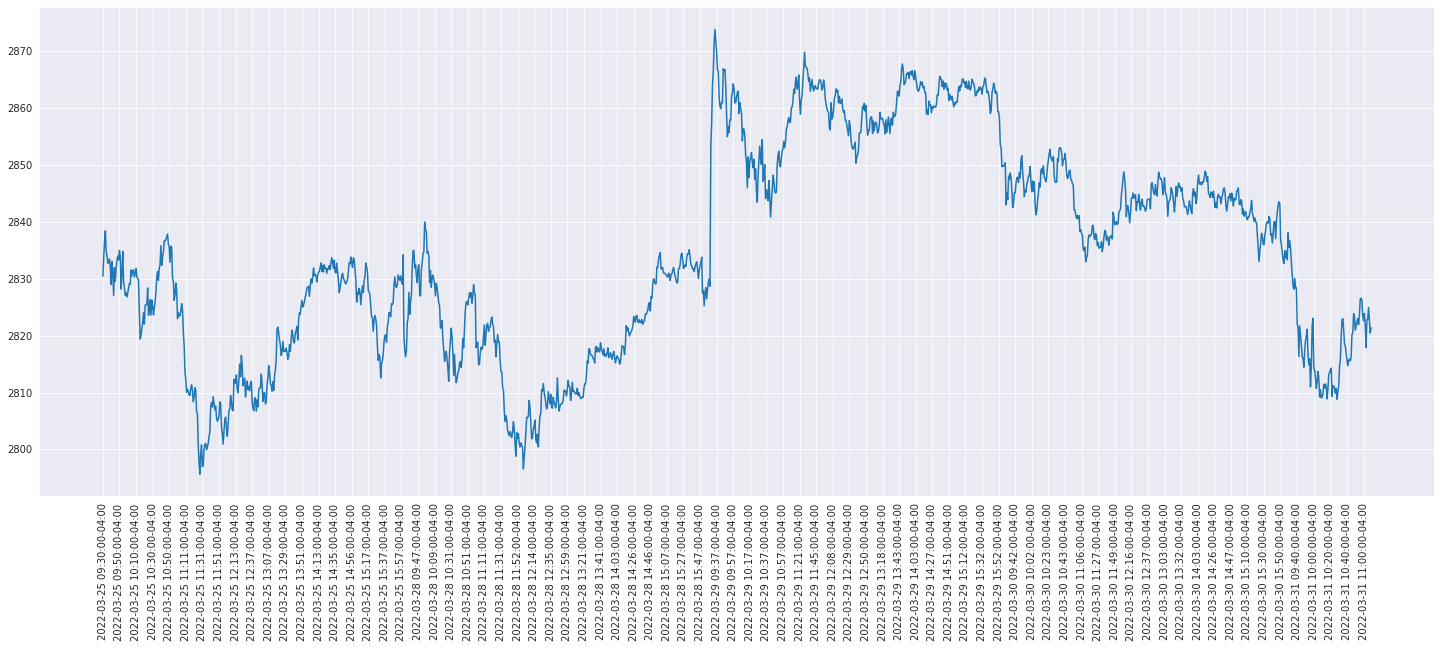

In [212]:
def plot_stock(hist):
  """
  Plot the stock price
  Parameters:
          hist (dict) : the history of the data
  """
  fig, ax = plt.subplots(figsize=(25, 9))
  x = np.arange(len(hist['Close']))
  y = hist['Close']
  plt.plot(x,y)
  plt.xticks(x[::20], hist.index[::20], rotation='vertical')
  plt.show()
plot_stock(hist)

Now let's change for longer period and interval:


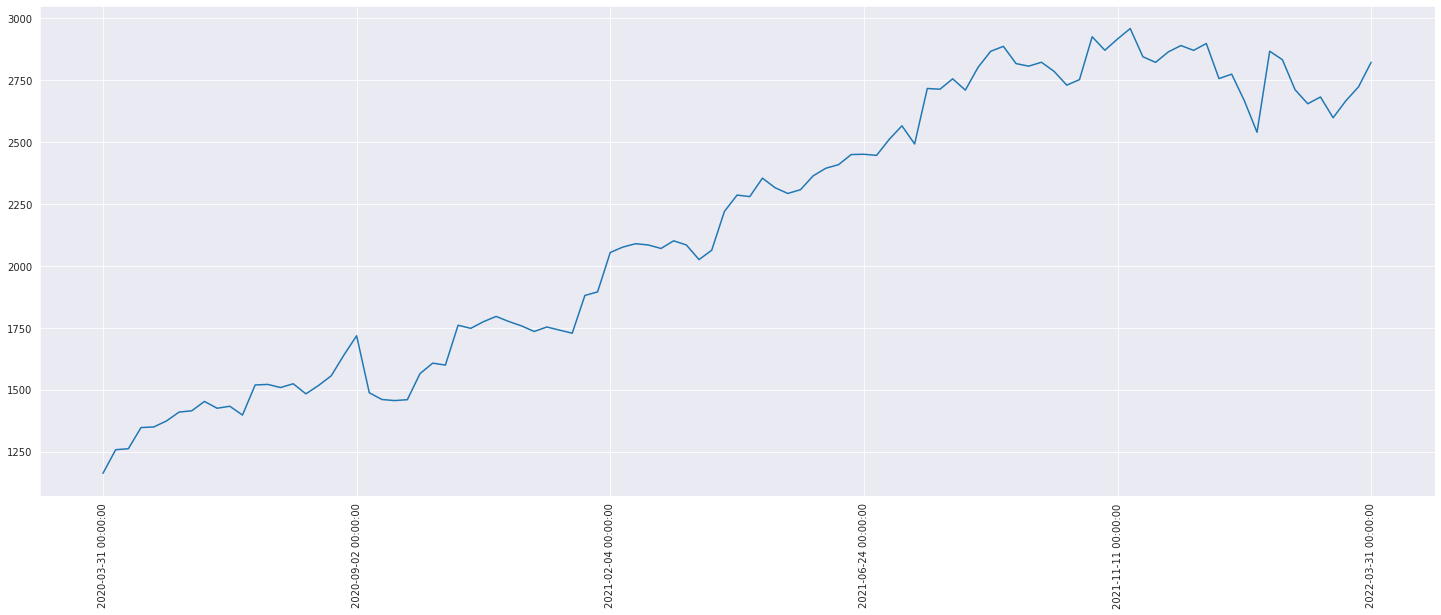

In [213]:
hist = pd.DataFrame(data.tickers['GOOGL'].history(period='2y', interval='5d'))
plot_stock(hist)

As expected, the curve varies much less quickly (is smoother) when the interval is larger. This could influence the prediction since the problem is made 'easier'.

## Exploring and cleaning data

Before diving into the model, let's explore the data provided by `yfinance`. 

### Yfinance functions

Here we just try some functions furnished in the [documentation](https://pypi.org/project/yfinance/) 

In [214]:
data = yf.Ticker('GOOGL')

# show actions (dividends, splits)
data.actions

# show dividends
data.dividends

# show splits
data.splits

# show financials
data.financials
data.quarterly_financials

# show major holders
data.major_holders

# show institutional holders
data.institutional_holders

# show balance sheet
data.balance_sheet
data.quarterly_balance_sheet

# show cashflow
data.cashflow
data.quarterly_cashflow

# show earnings
data.earnings
data.quarterly_earnings

# show sustainability
data.sustainability

# show analysts recommendations
data.recommendations

# show next event (earnings, etc)
data.calendar

# show ISIN code - *experimental*
# ISIN = International Securities Identification Number
data.isin

# show options expirations
data.options

# show news
data.news

[{'link': 'https://finance.yahoo.com/m/865263b4-b1ef-3b0a-8bfc-4c3cda1089da/is-snowflake-stock-a-buy-or.html',
  'providerPublishTime': 1648733267,
  'publisher': "Investor's Business Daily",
  'title': 'Is Snowflake Stock A Buy Or Sell Amid Software Sector Volatility?',
  'type': 'STORY',
  'uuid': '865263b4-b1ef-3b0a-8bfc-4c3cda1089da'},
 {'link': 'https://finance.yahoo.com/m/07be4bbb-f67f-3942-b632-8eae330fe8d0/is-google-stock-a-buy-as.html',
  'providerPublishTime': 1648732204,
  'publisher': "Investor's Business Daily",
  'title': 'Is Google Stock A Buy As Amazon, Facebook, Netflix Ride Roller-Coaster?',
  'type': 'STORY',
  'uuid': '07be4bbb-f67f-3942-b632-8eae330fe8d0'},
 {'link': 'https://finance.yahoo.com/m/7b95ac6a-b963-3477-a5fc-964281a13487/3-unstoppable-investments.html',
  'providerPublishTime': 1648731600,
  'publisher': 'Motley Fool',
  'title': '3 Unstoppable Investments Everyone Needs in Their Portfolio',
  'type': 'STORY',
  'uuid': '7b95ac6a-b963-3477-a5fc-964281a13

In [215]:
# get option chain for specific expiration
opt = data.option_chain('2022-04-01')
# data available via: opt.calls, opt.puts
opt.puts

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,GOOGL220401P01500000,2022-03-15 16:28:55+00:00,1500.0,0.10,0.0,0.05,0.0,0.0,1.0,4,2.460941,False,REGULAR,USD
1,GOOGL220401P01550000,2022-03-16 16:07:01+00:00,1550.0,0.05,0.0,0.05,0.0,0.0,NaN,2,2.343754,False,REGULAR,USD
2,GOOGL220401P01600000,2022-03-29 14:08:03+00:00,1600.0,0.07,0.0,0.00,0.0,0.0,3.0,4,0.500005,False,REGULAR,USD
3,GOOGL220401P01650000,2022-03-30 17:56:50+00:00,1650.0,0.02,0.0,0.05,0.0,0.0,1.0,3,2.109380,False,REGULAR,USD
4,GOOGL220401P01700000,2022-03-30 17:56:50+00:00,1700.0,0.02,0.0,0.05,0.0,0.0,1.0,3,1.992188,False,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,GOOGL220401P03600000,2022-03-15 15:54:54+00:00,3600.0,1015.40,773.9,777.80,0.0,0.0,NaN,0,0.000010,True,REGULAR,USD
159,GOOGL220401P03650000,2022-03-16 18:03:31+00:00,3650.0,1042.20,825.5,829.30,0.0,0.0,NaN,0,1.261722,True,REGULAR,USD
160,GOOGL220401P03750000,2022-03-01 16:11:27+00:00,3750.0,1042.15,925.1,929.80,0.0,0.0,NaN,0,1.543215,True,REGULAR,USD
161,GOOGL220401P03850000,2022-03-24 14:35:35+00:00,3850.0,1078.04,1024.6,1027.70,0.0,0.0,1.0,0,0.000010,True,REGULAR,USD


### Create the dataset 

In a first part, we want to use past data to train and test our model. For that purpose we create an artificial stream of data.

#### Yfinance version

Because River takes a specific type of input (dict) we create the dataset accordingly.

In terms of features, we first take only the one given in yfinance API (feature engineering in further part). y is the next close price. In order to be able to test our model, we save the next close price in ```y```. In practice, this data is not available : we only have the actual close price.


We use ```iter_pandas``` from river to create the stream from the dictionary. 



In [216]:
def construction_dataset(ticker='GOOGL',period='5d', interval='1m'):
  """
  Create a stream of stock data
  Parameters:
            ticker (str) : the company we want to study
            period (str) : the period of time 
            interval (str) : the interval of time between two requests
  """
  data = yf.Ticker(ticker)
  data_ = data.history(period=period, interval=interval)
  X = data_.iloc[:-1,:]
  y = data_['Close'].iloc[1:]
  return iter_pandas(X=X, y=y)

In [217]:
def construction_dataset_sklearn(ticker='GOOGL',period='5d', interval='1m'):
  data = yf.Ticker(ticker)
  data_ = data.history(period=period, interval=interval)
  X = data_.iloc[:-1,:]
  y = data_['Close'].iloc[1:]
  return X,y

In [218]:
ticker='GOOGL'
period='5d'
interval='1m'
data = yf.Ticker(ticker)
data_ = data.history(period=period, interval=interval)
X = data_.iloc[:-1,:]
X.Open



Datetime
2022-03-25 09:30:00-04:00    2838.320068
2022-03-25 09:31:00-04:00    2830.843506
2022-03-25 09:32:00-04:00    2835.879883
2022-03-25 09:33:00-04:00    2838.445068
2022-03-25 09:34:00-04:00    2836.250000
                                ...     
2022-03-31 11:05:00-04:00    2822.729980
2022-03-31 11:06:00-04:00    2823.550049
2022-03-31 11:07:00-04:00    2822.574951
2022-03-31 11:08:00-04:00    2819.979980
2022-03-31 11:09:00-04:00    2821.383789
Name: Open, Length: 1530, dtype: float64

In [219]:
construction_dataset(ticker='GOOGL',period='7d', interval='1m')

<generator object iter_pandas at 0x7efb8ec18dd0>

Let's visualize the first 5 inputs : 

In [220]:
#example visualisation
for i,(x,y) in enumerate(construction_dataset(period='7d', interval='1m')):
  print(x,y)
  print()
  if i>5:
    break

{'Open': 2774.050048828125, 'High': 2784.989990234375, 'Low': 2772.59765625, 'Close': 2780.169921875, 'Volume': 53820.0, 'Dividends': 0.0, 'Stock Splits': 0.0} 2775.0

{'Open': 2776.179931640625, 'High': 2776.179931640625, 'Low': 2775.0, 'Close': 2775.0, 'Volume': 11899.0, 'Dividends': 0.0, 'Stock Splits': 0.0} 2771.449951171875

{'Open': 2771.449951171875, 'High': 2771.449951171875, 'Low': 2771.449951171875, 'Close': 2771.449951171875, 'Volume': 4872.0, 'Dividends': 0.0, 'Stock Splits': 0.0} 2773.5

{'Open': 2770.0, 'High': 2773.5, 'Low': 2770.0, 'Close': 2773.5, 'Volume': 3807.0, 'Dividends': 0.0, 'Stock Splits': 0.0} 2775.919921875

{'Open': 2774.37744140625, 'High': 2775.919921875, 'Low': 2774.37744140625, 'Close': 2775.919921875, 'Volume': 3865.0, 'Dividends': 0.0, 'Stock Splits': 0.0} 2777.909912109375

{'Open': 2773.0, 'High': 2777.909912109375, 'Low': 2773.0, 'Close': 2777.909912109375, 'Volume': 4378.0, 'Dividends': 0.0, 'Stock Splits': 0.0} 2776.080078125

{'Open': 2777.68994

## Feature engeeniring

In [221]:
X.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2022-03-25 09:30:00-04:00,2838.320068,2840.000000,2825.270020,2830.469971,97164,0,0
2022-03-25 09:31:00-04:00,2830.843506,2834.169922,2830.843506,2833.449951,2818,0,0
2022-03-25 09:32:00-04:00,2835.879883,2837.899902,2835.370117,2836.635010,4897,0,0
2022-03-25 09:33:00-04:00,2838.445068,2838.445068,2838.445068,2838.445068,6215,0,0
2022-03-25 09:34:00-04:00,2836.250000,2836.790039,2834.939941,2834.939941,4913,0,0


Here are our 7 columns 

In [222]:
X_cop = X.copy()

In [223]:
X_cop['Dividends']!=0
X_cop['Stock Splits']!=0

Datetime
2022-03-25 09:30:00-04:00    False
2022-03-25 09:31:00-04:00    False
2022-03-25 09:32:00-04:00    False
2022-03-25 09:33:00-04:00    False
2022-03-25 09:34:00-04:00    False
                             ...  
2022-03-31 11:05:00-04:00    False
2022-03-31 11:06:00-04:00    False
2022-03-31 11:07:00-04:00    False
2022-03-31 11:08:00-04:00    False
2022-03-31 11:09:00-04:00    False
Name: Stock Splits, Length: 1530, dtype: bool

In [224]:
X_cop.drop(labels=['Dividends', 'Stock Splits'], axis=1)

,Open,High,Low,Close,Volume
Datetime,,,,,
2022-03-25 09:30:00-04:00,2838.320068,2840.000000,2825.270020,2830.469971,97164
2022-03-25 09:31:00-04:00,2830.843506,2834.169922,2830.843506,2833.449951,2818
2022-03-25 09:32:00-04:00,2835.879883,2837.899902,2835.370117,2836.635010,4897
2022-03-25 09:33:00-04:00,2838.445068,2838.445068,2838.445068,2838.445068,6215
2022-03-25 09:34:00-04:00,2836.250000,2836.790039,2834.939941,2834.939941,4913
...,...,...,...,...,...
2022-03-31 11:05:00-04:00,2822.729980,2823.479980,2822.212402,2822.940186,3183
2022-03-31 11:06:00-04:00,2823.550049,2826.370117,2823.550049,2824.949951,2499
2022-03-31 11:07:00-04:00,2822.574951,2822.665039,2822.574951,2822.665039,1093


In [225]:
X_cop.columns


Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')

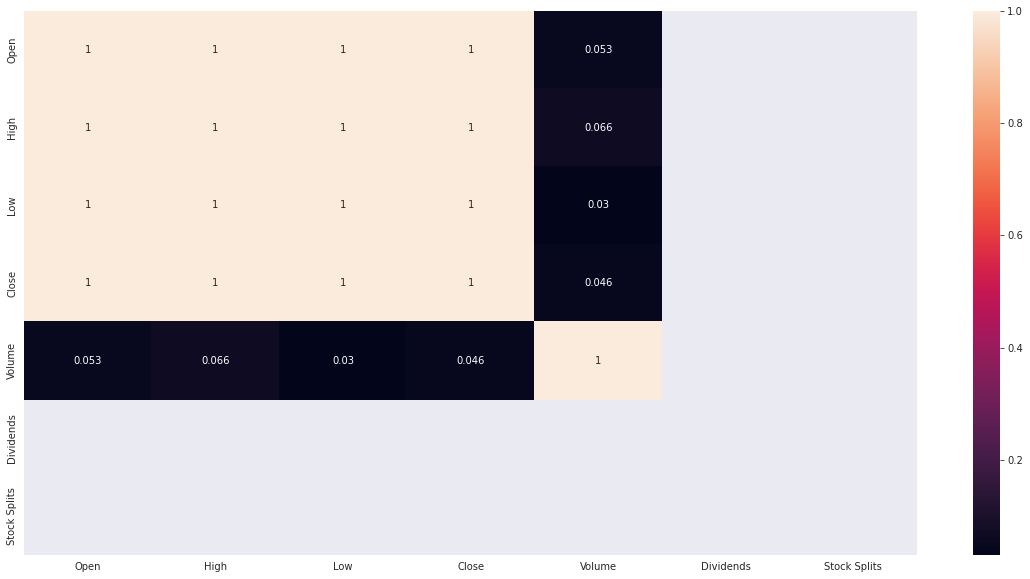

In [226]:
plt.figure(figsize = (20,10))
sns.heatmap(X_cop.corr(), annot = True)

In [227]:
X_cop['omean'] = X_cop.Open.mean()
X_cop['ostd'] = X_cop.Open.std()
X_cop['osum'] = X_cop.Open.sum()
X_cop['vsum'] = X_cop.Volume.sum()
X_cop['diffclose'] = X_cop.iloc[-1].Close - X_cop.iloc[-2].Close

In [228]:
X_cop

,Open,High,Low,Close,Volume,Dividends,Stock Splits,omean,ostd,osum,vsum,diffclose
Datetime,,,,,,,,,,,,
2022-03-25 09:30:00-04:00,2838.320068,2840.000000,2825.270020,2830.469971,97164,0,0,2834.592542,18.431778,4.336927e+06,4985917,0.913818
2022-03-25 09:31:00-04:00,2830.843506,2834.169922,2830.843506,2833.449951,2818,0,0,2834.592542,18.431778,4.336927e+06,4985917,0.913818
2022-03-25 09:32:00-04:00,2835.879883,2837.899902,2835.370117,2836.635010,4897,0,0,2834.592542,18.431778,4.336927e+06,4985917,0.913818
2022-03-25 09:33:00-04:00,2838.445068,2838.445068,2838.445068,2838.445068,6215,0,0,2834.592542,18.431778,4.336927e+06,4985917,0.913818
2022-03-25 09:34:00-04:00,2836.250000,2836.790039,2834.939941,2834.939941,4913,0,0,2834.592542,18.431778,4.336927e+06,4985917,0.913818
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-31 11:05:00-04:00,2822.729980,2823.479980,2822.212402,2822.940186,3183,0,0,2834.592542,18.431778,4.336927e+06,4985917,0.913818
2022-03-31 11:06:00-04:00,2823.550049,2826.370117,2823.550049,2824.949951,2499,0,0,2834.592542,18.431778,4.336927e+06,4985917,0.913818
2022-03-31 11:07:00-04:00,2822.574951,2822.665039,2822.574951,2822.665039,1093,0,0,2834.592542,18.431778,4.336927e+06,4985917,0.913818


## Model using River

River expects data observations to be presented as python dictionaries. The dictionary keys representing feature names. Here we face a regression model. For that purpose we'll test some models from River which could be relevant for this task:


*   Linear regression
*   Stochastic Gradient Tree
*   Hoeffding Tree
*   Hoeffding Adaptive Tree



First we implement a function to train and evaluate a model, using `tqdm` will be useful to track the efficiency of our model, in terms of MAE, MSE and RMSE. We also tried to track the rolling MSE and MAE.


In [229]:
def evaluate_fc(stream, model, n_wait=3,verbose=False):
    MSE = metrics.MSE()
    MSE_rolling = metrics.Rolling(metric=metrics.MSE(), window_size=n_wait)
    MAE =  metrics.MAE()
    MAE_rolling = metrics.Rolling(metric=metrics.MAE(), window_size=n_wait)
    RMSE = metrics.RMSE()
    raw_results = []
    true_y = []
    pred_y = []
    mae = []
    rmse = []
    model_name = model.__class__.__name__
    with tqdm(stream, unit="stream") as tstream:
      for i, (x, y) in enumerate(tstream):
         tstream.set_description(f"Sample processed {i}")
         # Predict
         #print(x)
         y_pred = model.predict_one(x)
         true_y.append(y)
         pred_y.append(y_pred)
         # Update metrics and results
         MSE=MSE.update(y_true=y, y_pred=y_pred)
         MSE_rolling=MSE_rolling.update(y_true=y, y_pred=y_pred)
         RMSE = RMSE.update(y_true=y, y_pred=y_pred)
         MAE = MAE.update(y_true=y, y_pred=y_pred)
         MAE_rolling = MAE_rolling.update(y_true=y, y_pred=y_pred)
         mae.append(MAE.get())
         rmse.append(RMSE.get()) 
         raw_results.append([model_name, i, MSE.get(), MSE_rolling.get(), MAE.get(), MAE_rolling.get()])
         # Learn (train)
         model.learn_one(x, y)
         tstream.set_postfix(MAE=MAE.get(), MSE=MSE.get(), RMSE = RMSE.get(), RollingMSE = MSE_rolling.get(), RollingMAE = MAE_rolling.get())
         if verbose:
           sleep(0.1)
    return pd.DataFrame(raw_results, columns=['model', 'id', 'MSE', 'MSE_roll', 'MAE', 'MAE_roll']), mae, true_y, pred_y


In [230]:
ticker='GOOGL'

### Simple Linear regression

In [231]:
lr_results_1h = evaluate_fc(stream=construction_dataset(ticker=ticker,period='1y', interval='1h'),
                      model=(
                      preprocessing.StandardScaler() |
                      linear_model.LinearRegression(intercept_lr=.1)), 
                      verbose=False)

lr_results_1m = evaluate_fc(stream=construction_dataset(ticker=ticker,period='7d', interval='1m'),
                      model=(
                      preprocessing.StandardScaler() |
                      linear_model.LinearRegression(intercept_lr=.1)), 
                      verbose=False)

Sample processed 1768: : 1769stream [00:06, 262.73stream/s, MAE=24, MSE=7.94e+3, RMSE=89.1, RollingMAE=11.6, RollingMSE=237]
Sample processed 2240: : 2241stream [00:08, 270.38stream/s, MAE=13.9, MSE=9.89e+3, RMSE=99.5, RollingMAE=4.98, RollingMSE=32.8]


In [232]:
def plot_results(results_1h, model, results_1m=None, both=True):
   if both:
     plt.subplots(figsize=(40,20))
     plt.subplot(2,1,1)
   plt.plot(results_1h[-1][15:], '--', c='b', label='predicted')
   plt.plot(results_1h[-2][15:], '--',c='g', label='true' )
   plt.legend()
   plt.title(f'Result with {model}, a period of 1 year and 1h intervals')
   if both:
     plt.subplot(2,1,2)
     plt.plot(results_1m[-1][15:], '--', c='b', label='predicted')
     plt.plot(results_1m[-2][15:], '--',c='g', label='true' )
     plt.legend()
     plt.title(f'Result with {model}, a period of 7 days and 1 minute intervals')
   plt.show()

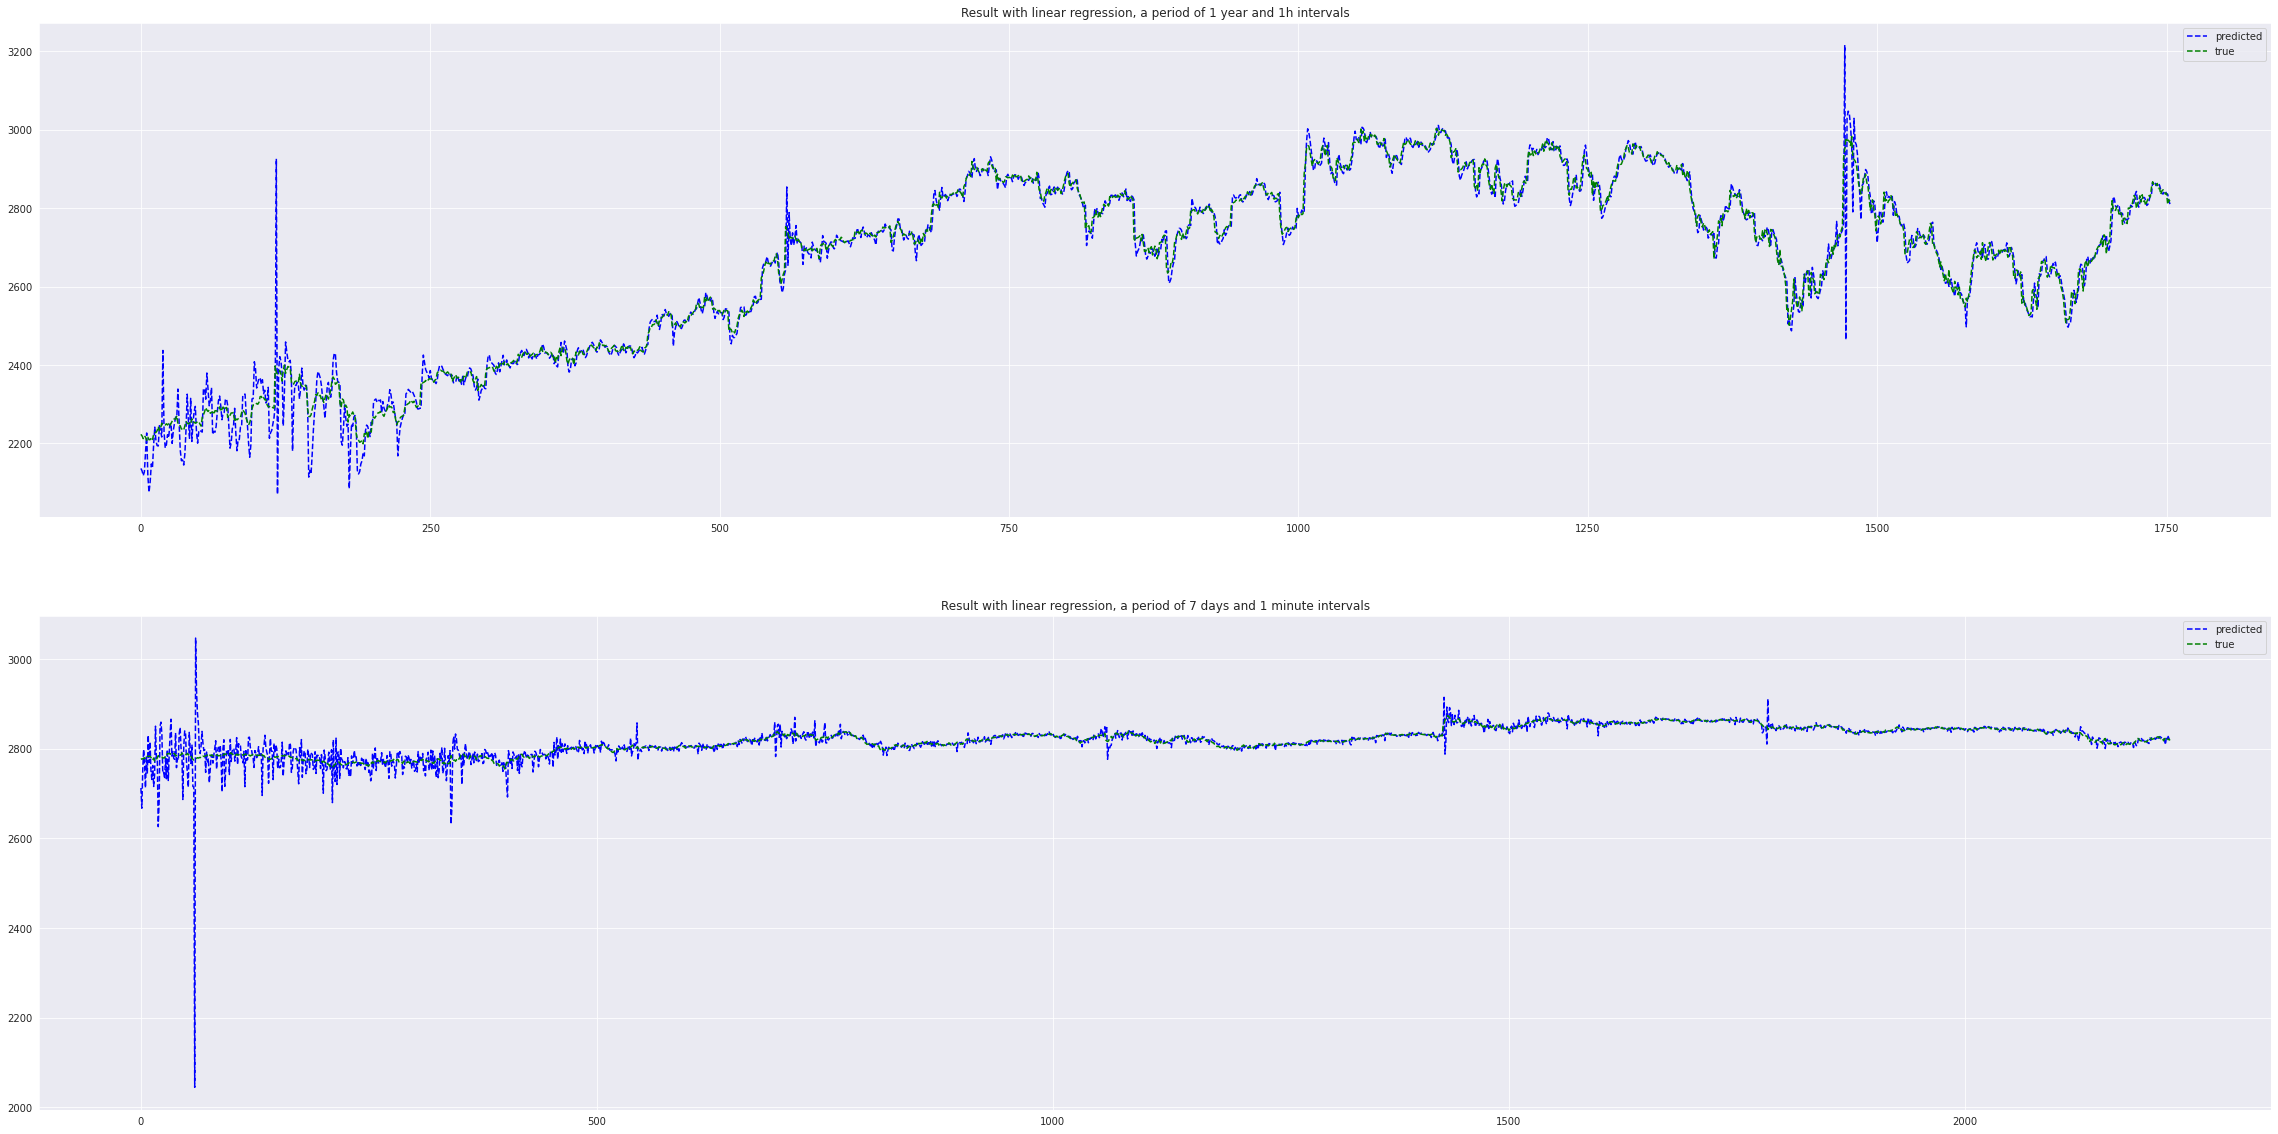

In [233]:
plot_results(lr_results_1h, 'linear regression', lr_results_1m, both=True)

As we can see, our intuition from the previous part is verified, a same model seems to have more difficulty when the interval of time between two stream events is shorter.
Moreover, we can visually see that this simple linear regression performs very well. Actually, if we zoom in the figure, it seems like the model is actually predicting the same curve as the original but a little bit shifted in the time axis... This is a plausible hypothesis since it seems impossible to predict the curve as well without the model being biased when learning and predicting.

In [234]:
print(lr_results_1h[-1][100:130])
print(lr_results_1h[-2][99:129])

[2209.8387296919745, 2241.391826420578, 2242.372764942776, 2322.076925209955, 2325.607944595292, 2325.738749086403, 2271.9693193947073, 2248.5489208996396, 2201.241569383231, 2164.880030578125, 2196.5381846460027, 2313.625464275762, 2314.432122814849, 2408.366219072488, 2390.5414519811297, 2341.345443722849, 2354.8483032382637, 2365.5785658799523, 2367.5306577686692, 2351.997699497599, 2362.5046780183247, 2326.964452084544, 2335.7361587916507, 2303.372782114281, 2310.6591010762186, 2343.1674521790806, 2213.3090773220274, 2227.261794646231, 2233.2033545855315, 2250.0240972514134]
[2263.0, 2265.489990234375, 2266.64990234375, 2278.340087890625, 2285.514404296875, 2281.239990234375, 2276.889892578125, 2263.72509765625, 2255.0, 2247.080078125, 2252.860107421875, 2264.530029296875, 2288.119873046875, 2298.22998046875, 2298.06005859375, 2298.389892578125, 2302.27001953125, 2299.93994140625, 2304.889892578125, 2319.35009765625, 2319.875, 2313.840087890625, 2317.14990234375, 2311.47998046875, 

Actually, the model is not predicting exactly the previous value.. Let's explore more advanced models.

### SGT Regressor

Stochastic Gradient Tree is an incremental decision tree regressor that minimizes the mean square error to guide tree growth and update their predictions. Thus, they differ from other incrementally tree learners that do not directly optimize the loss, but a data impurity-related heuristic (cf [River doc](https://riverml.xyz/latest/api/tree/SGTRegressor/)).

Sample processed 1768: : 1769stream [00:12, 139.25stream/s, MAE=130, MSE=7.47e+4, RMSE=273, RollingMAE=15.3, RollingMSE=236]
Sample processed 2240: : 2241stream [00:15, 146.90stream/s, MAE=32, MSE=6.9e+4, RMSE=263, RollingMAE=3.07, RollingMSE=12.7]


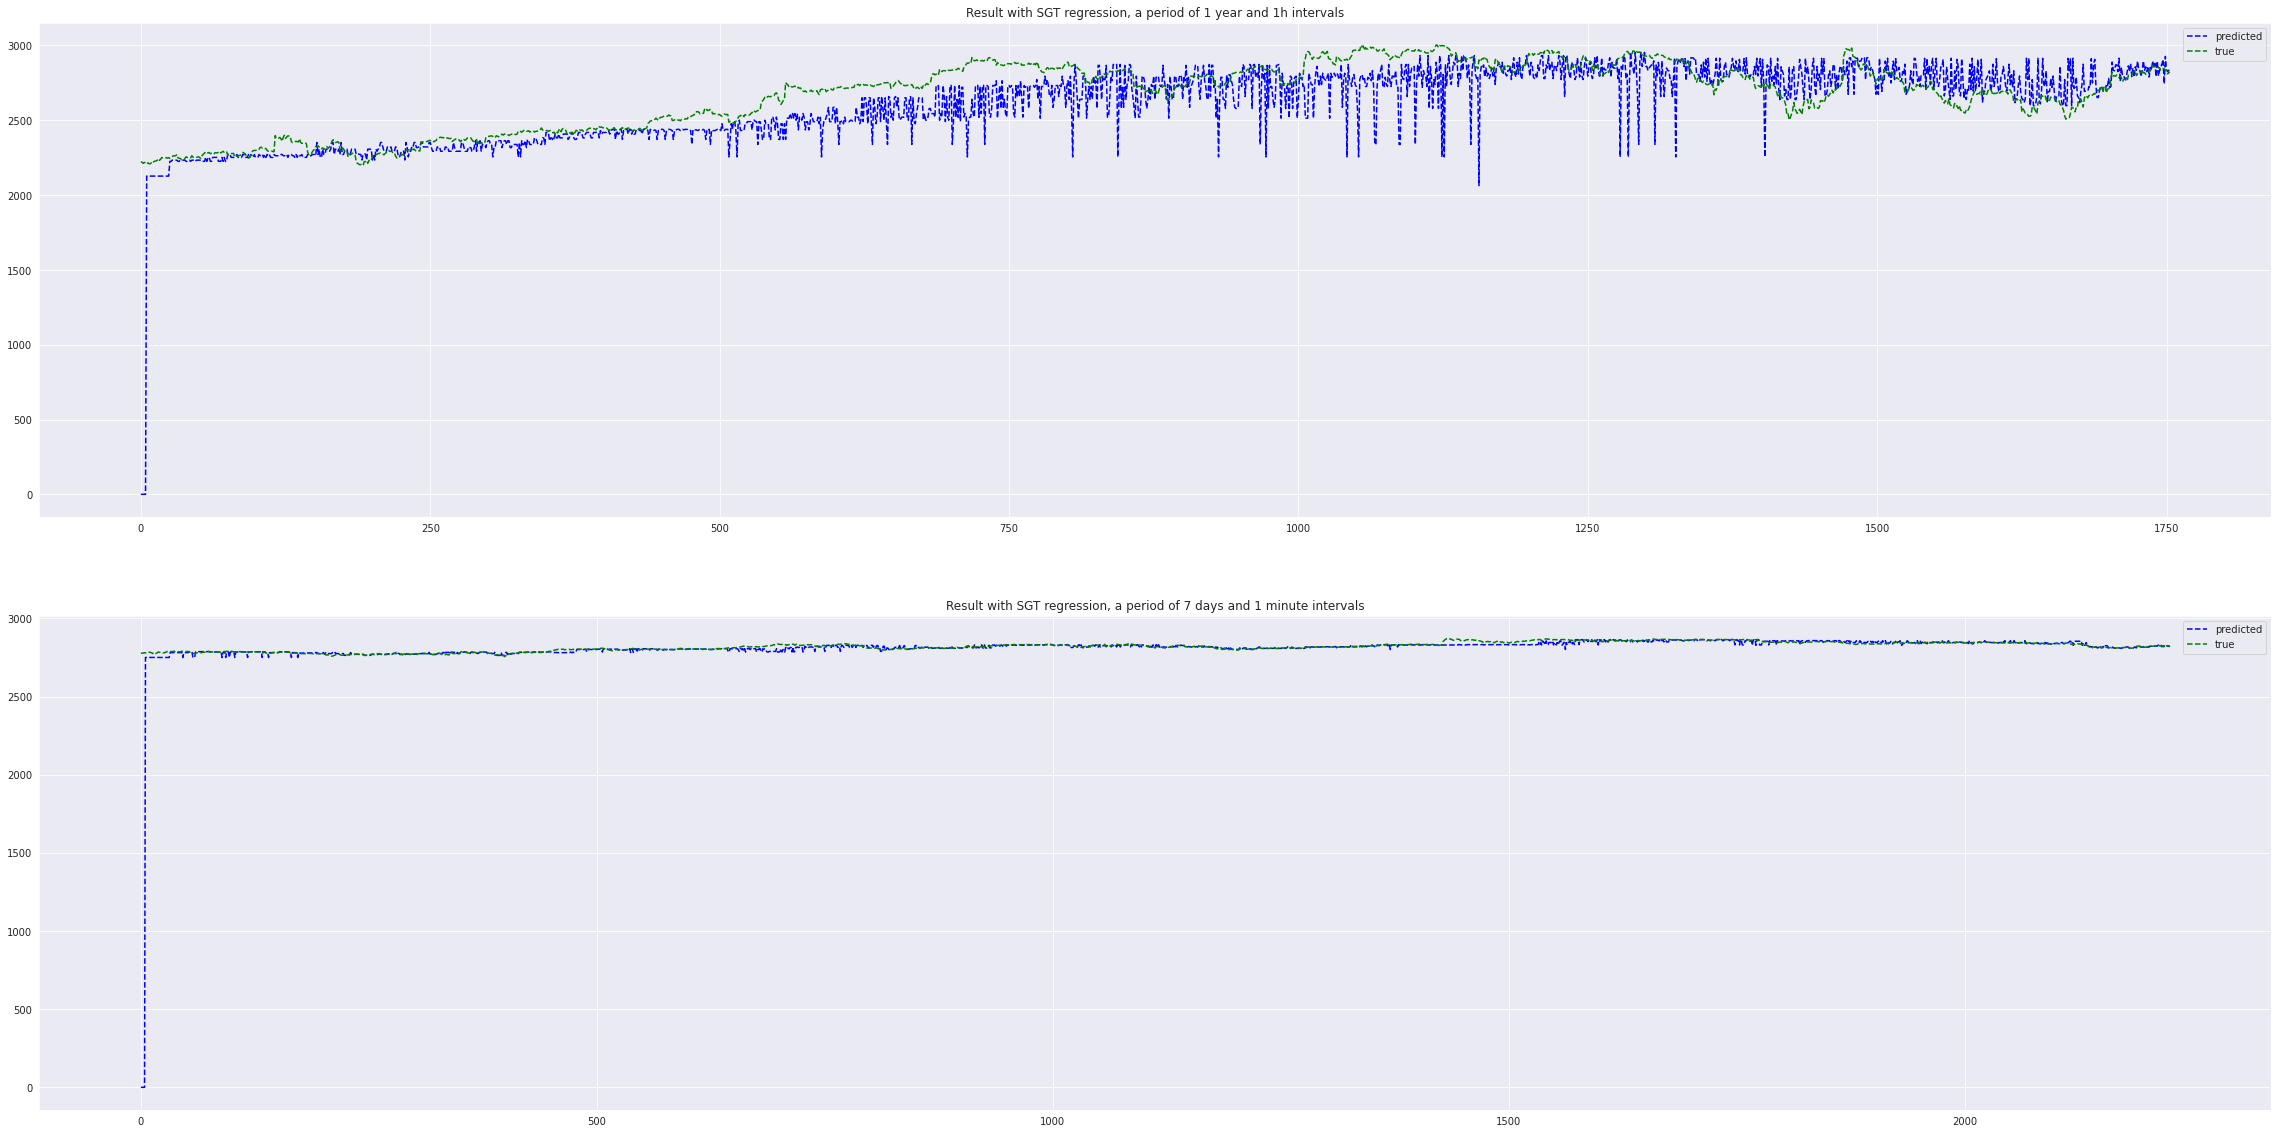

In [235]:
sgtr_results_1h = evaluate_fc(stream=construction_dataset(ticker=ticker,period='1y', interval='1h'),
                      model=SGTRegressor(
                          delta=0.01,
                          lambda_value=0.01,
                          grace_period=20,
                          feature_quantizer=tree.splitter.DynamicQuantizer(std_prop=0.1)), 
                      verbose=False)

sgtr_results_1m = evaluate_fc(stream=construction_dataset(ticker=ticker,period='7d', interval='1m'),
                      model=SGTRegressor(
                          delta=0.01,
                          lambda_value=0.01,
                          grace_period=20,
                          feature_quantizer=tree.splitter.DynamicQuantizer(std_prop=0.1)), 
                      verbose=False)

plot_results(sgtr_results_1h, 'SGT regression', sgtr_results_1m, both=True)


### Hoeffding Tree

In [236]:
model=(preprocessing.StandardScaler() |
       HoeffdingTreeRegressor(
           grace_period=100,
           leaf_prediction='adaptive',
           model_selector_decay=0.9)
        )
ht_results_1h = evaluate_fc(stream=construction_dataset(ticker=ticker,period='1y', interval='1h'),
                  model=model, 
                  verbose=False)

ht_results_1m = evaluate_fc(stream=construction_dataset(ticker=ticker,period='7d', interval='1m'),
                      model=model, 
                      verbose=False)

Sample processed 1768: : 1769stream [00:24, 71.46stream/s, MAE=50.8, MSE=9.41e+3, RMSE=97, RollingMAE=28.7, RollingMSE=862]
Sample processed 2241: : 2242stream [00:32, 68.69stream/s, MAE=3.43, MSE=26.1, RMSE=5.11, RollingMAE=3.38, RollingMSE=12.4]


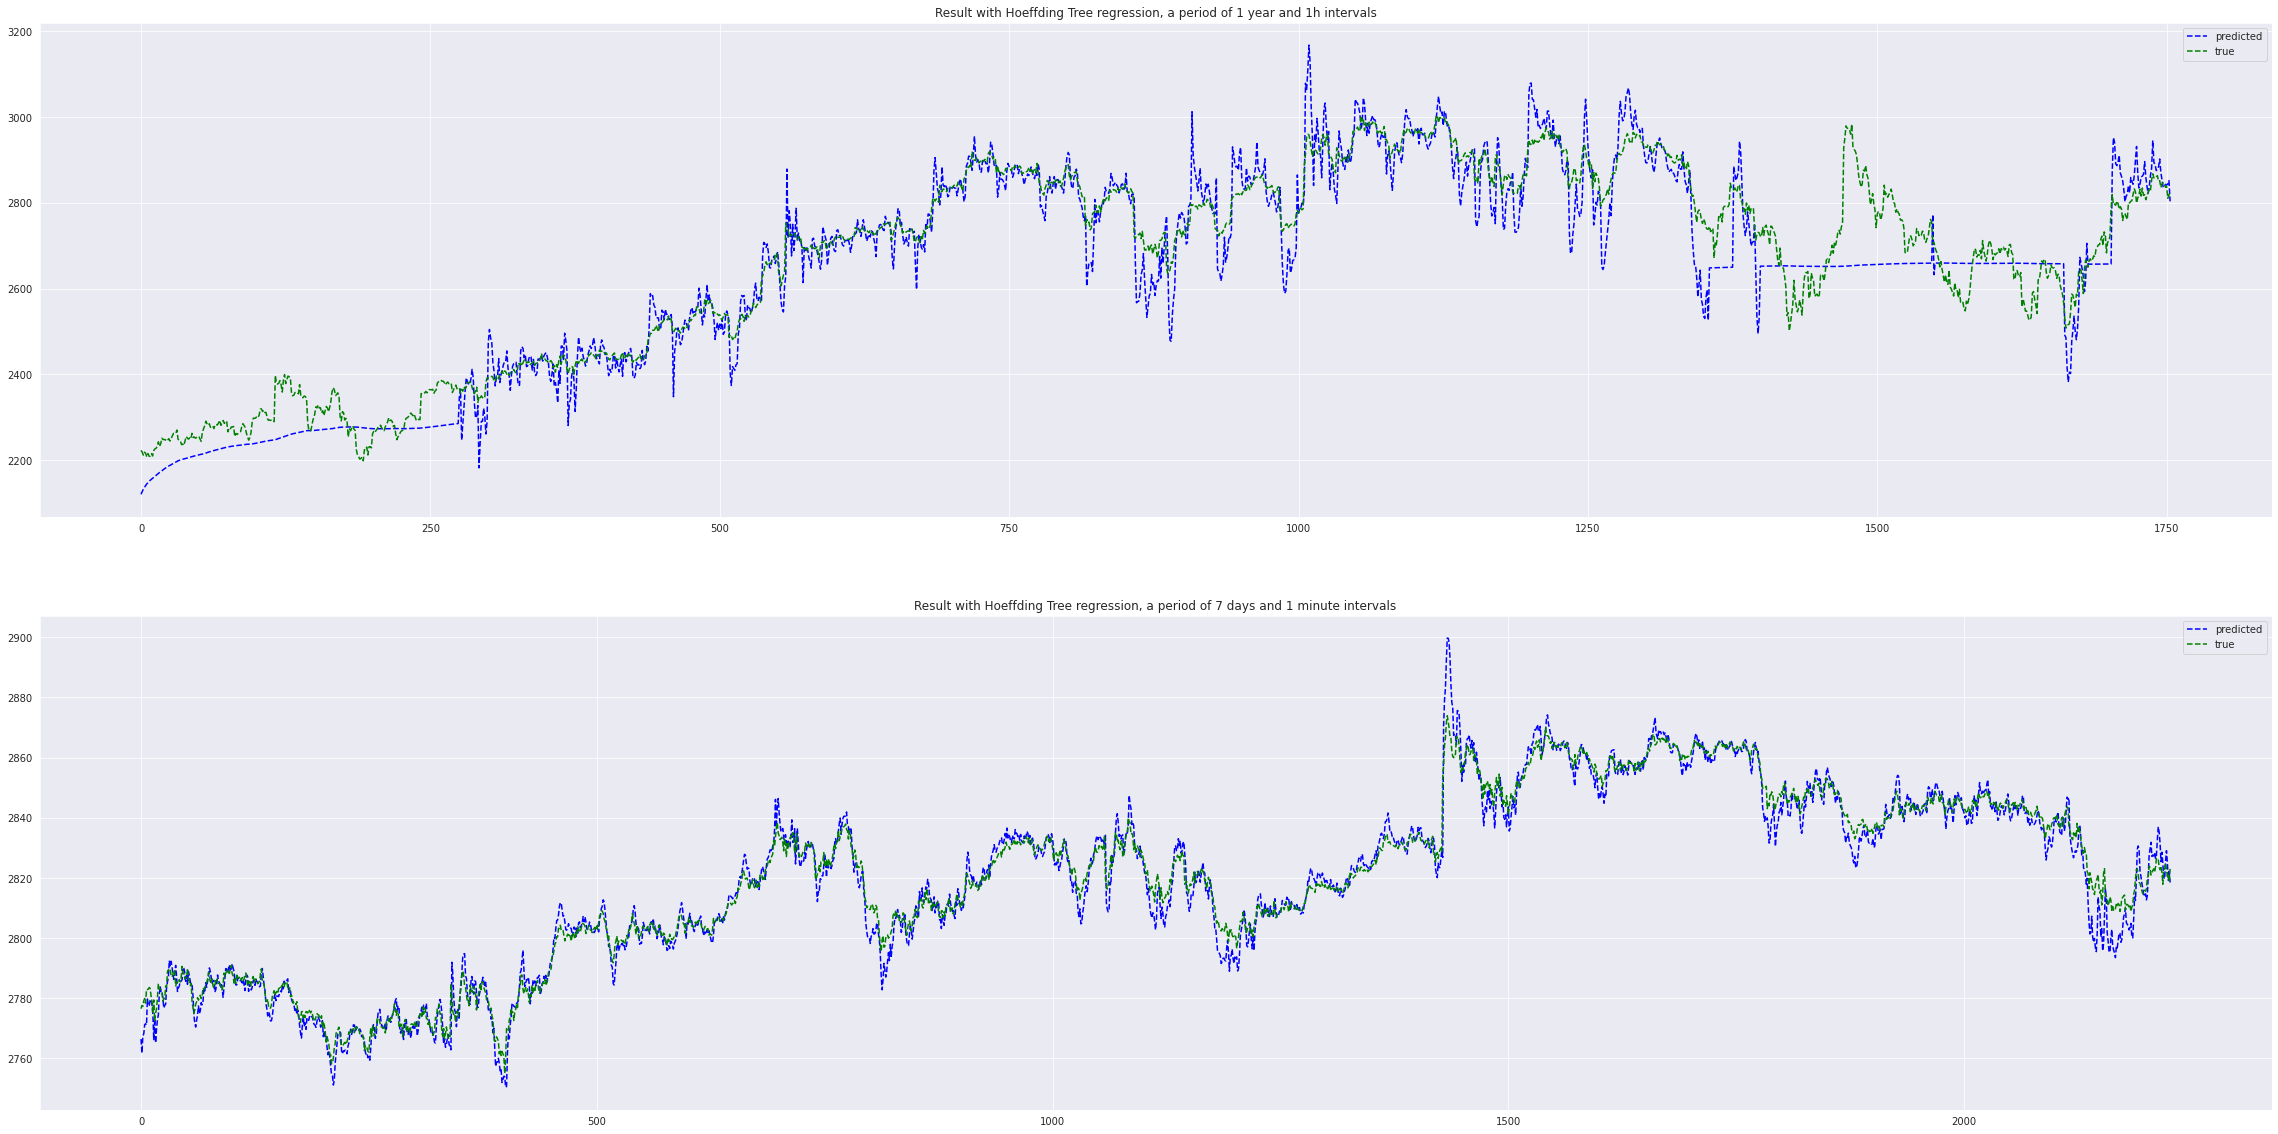

In [237]:
plot_results(ht_results_1h, 'Hoeffding Tree regression',ht_results_1m, both=True)


### Hoeffding Adaptive Tree

In [238]:
model=(preprocessing.StandardScaler() |
       HoeffdingAdaptiveTreeRegressor(
           grace_period=100,
           leaf_prediction='adaptive',
           model_selector_decay=0.9)
        )
hat_results_1h = evaluate_fc(stream=construction_dataset(ticker=ticker,period='1y', interval='1h'),
                       model=model, 
                       verbose=False)

hat_results_1m = evaluate_fc(stream=construction_dataset(ticker=ticker,period='7d', interval='1m'),
                       model=model, 
                       verbose=False)



Sample processed 1768: : 1769stream [00:19, 90.55stream/s, MAE=43.2, MSE=8.25e+3, RMSE=90.8, RollingMAE=24.2, RollingMSE=586]
Sample processed 2242: : 2243stream [00:23, 95.67stream/s, MAE=2.7, MSE=14.9, RMSE=3.86, RollingMAE=5.33, RollingMSE=31.3]


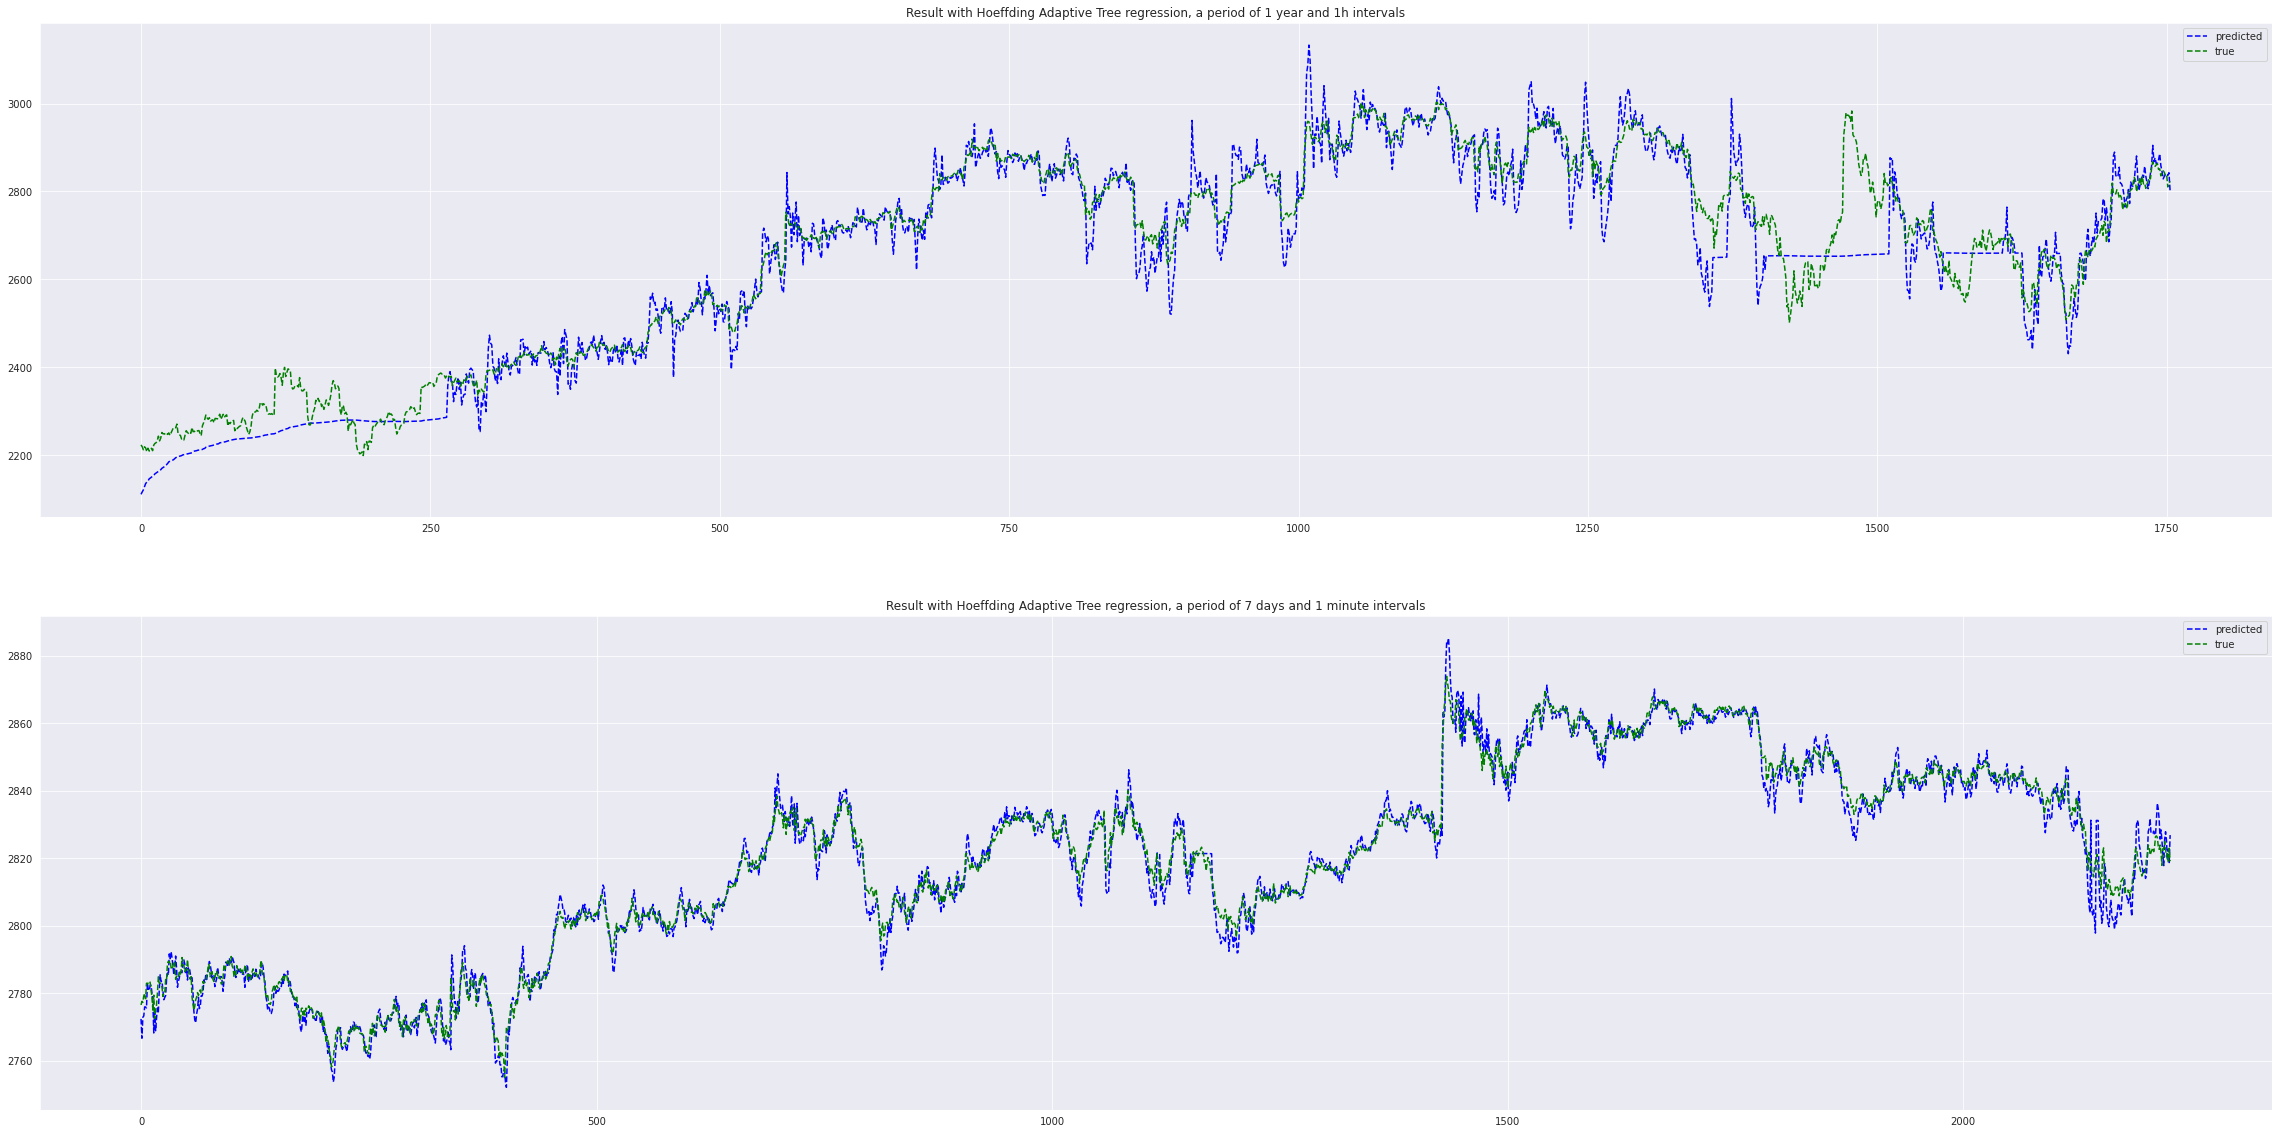

In [239]:
plot_results(hat_results_1h, 'Hoeffding Adaptive Tree regression',hat_results_1m, both=True)

**Metrics results on the different models**

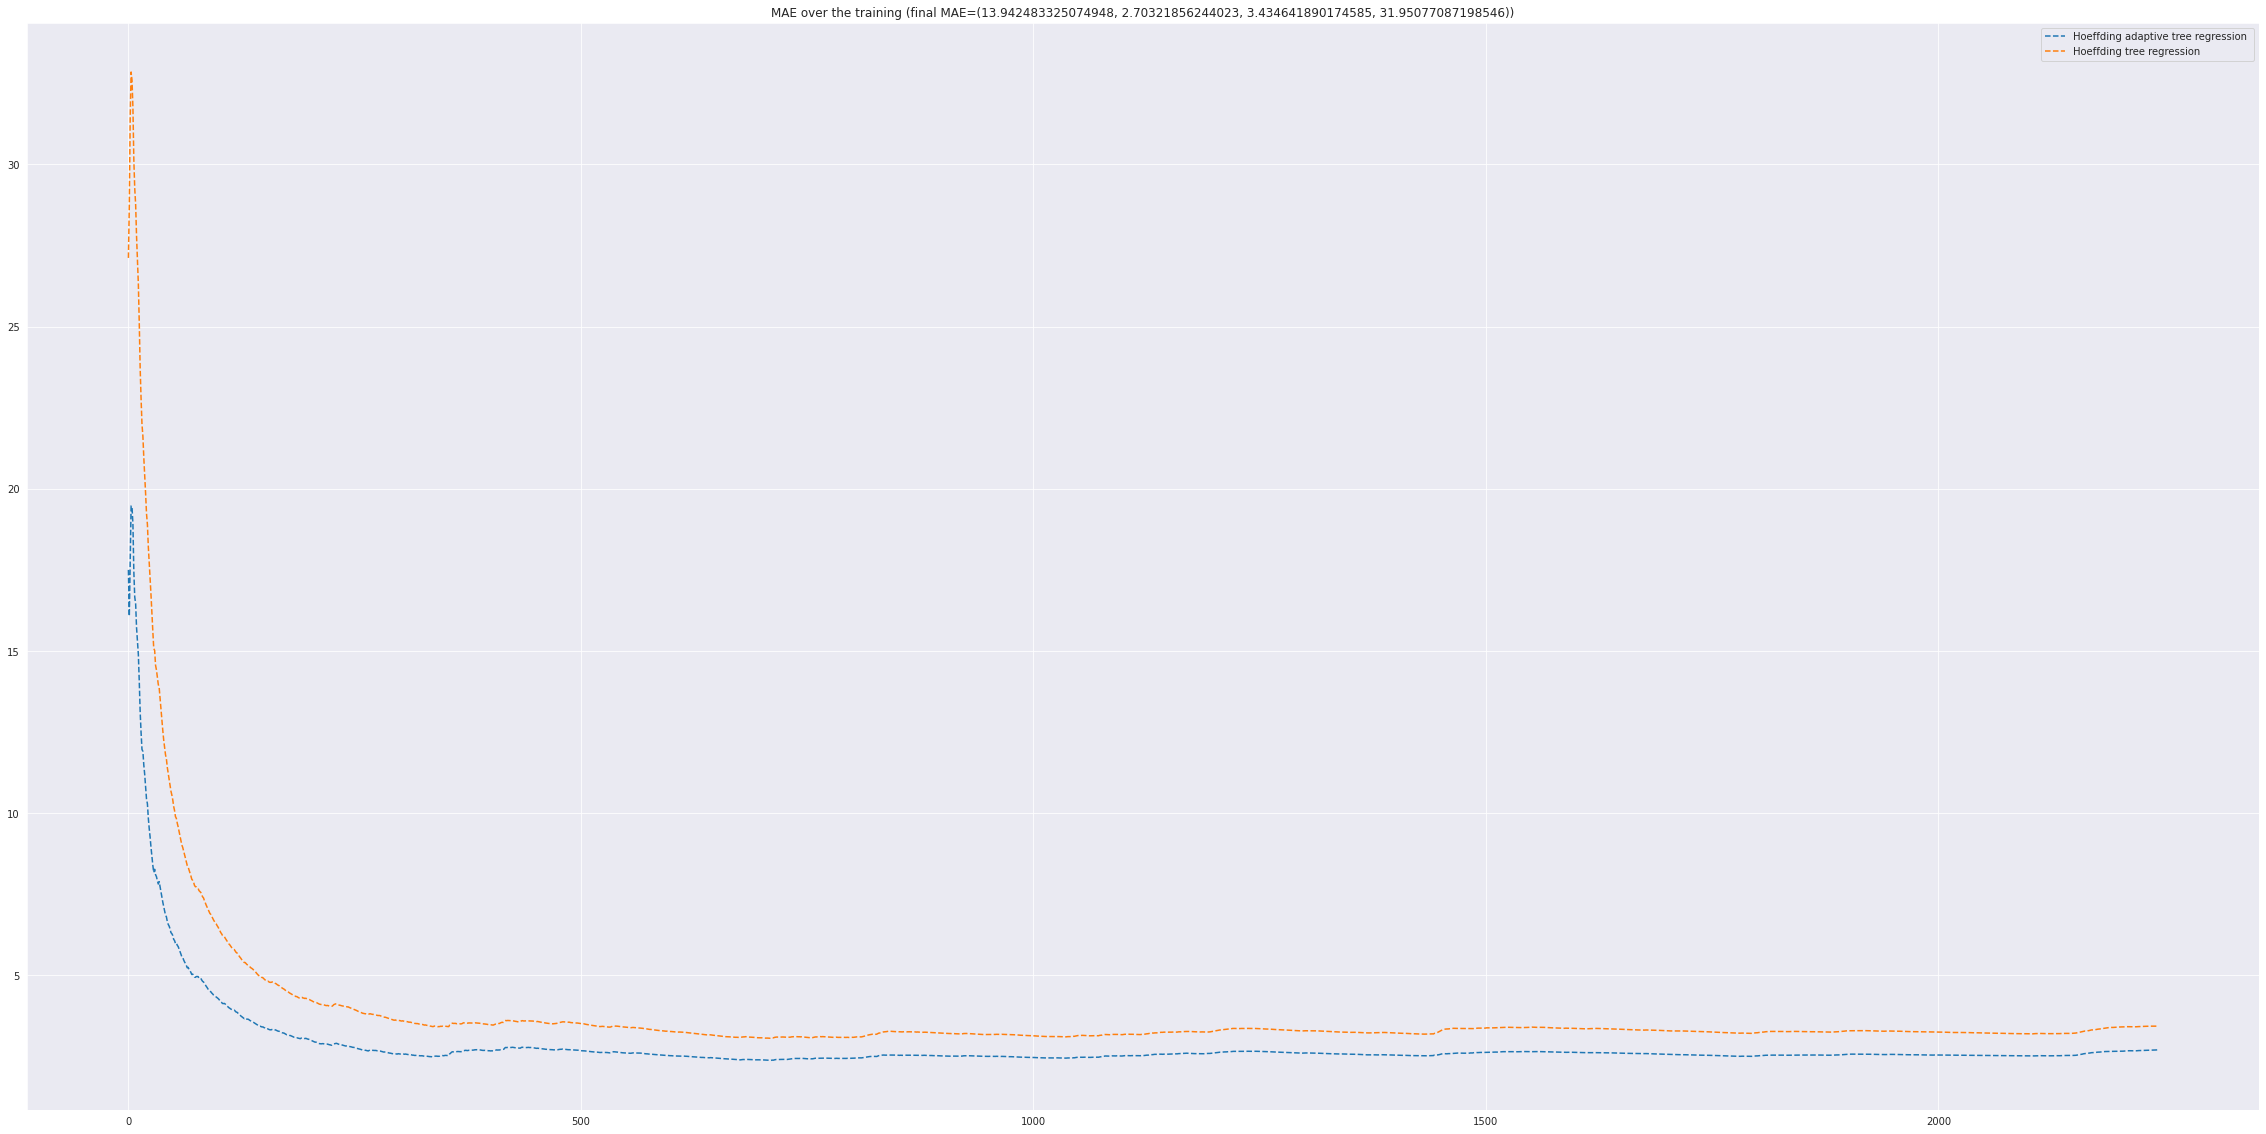

In [240]:

plt.figure(figsize=(40,20))
#plt.plot(lr_results_1m[3], '--', label='linear regression ')
plt.plot(hat_results_1m[-3], '--', label='Hoeffding adaptive tree regression ')
plt.plot(ht_results_1m[-3], '--', label='Hoeffding tree regression ')
#plt.plot(sgtr_results_1m[-3], '--', label='Stochastic Gradient Tree regression  ')
plt.legend()
plt.title(f'MAE over the training (final MAE={lr_results_1m[-3][-1],hat_results_1m[-3][-1],ht_results_1m[-3][-1],sgtr_results_1m[-3][-1]})')
plt.show()


The **Hoeffding Adaptive Tree** is the one giving the best results. Let's focus on this model and let's try to improve it by fine-tuning its hyperparameters. Here are some important parameters of the model (see [River doc](https://riverml.xyz/latest/api/tree/HoeffdingAdaptiveTreeRegressor/))

*  grace_period (int) – defaults to 200 (Number of instances a leaf should observe between split attempts.)

*  max_depth (int) – defaults to None (The maximum depth a tree can reach. If None, the tree will grow indefinitely.)

*  split_confidence (float) – defaults to 1e-07 (Allowed error in split decision, a value closer to 0 takes longer to decide.)

* Prediction mechanism used at leafs.
  - 'mean' - Target mean
  - 'model' - Uses the model defined in leaf_model
  - 'adaptive' - Chooses between 'mean' and 'model' dynamically

* leaf_model (base.Regressor) – defaults to None (The regression model used to provide responses if leaf_prediction='model'. If not provided an instance of river.linear_model.LinearRegression with the default hyperparameters is used.)

* model_selector_decay (float) – defaults to 0.95 (The exponential decaying factor applied to the learning models' squared errors, that are monitored if leaf_prediction='adaptive'. Must be between 0 and 1. The closer to 1, the more importance is going to be given to past observations. On the other hand, if its value approaches 0, the recent observed errors are going to have more influence on the final decision.)


In [241]:
search_param = False


if search_param == True: 
  parameters = {'grace_period':[100,200,300]}
  leaf_model = linear_model.Perceptron()
  for grace_period in [100,200,300]:
    for max_depth in [None, 100, 500]:
      for split_confidence in np.linspace(1e-09, 1e-05, 10):
        for leaf_prediction in ['adaptative', 'mean', 'model']:
          for model_selector_decay in np.linspace(0.8,0.99,10):
              print(f'grace_period:{grace_period},max_depth:{max_depth}, split_confidence:{split_confidence},leaf_prediction:{leaf_prediction},leaf_model:{leaf_model},model_selector_decay:{model_selector_decay}')
              hat = model=(preprocessing.StandardScaler() |
                          HoeffdingAdaptiveTreeRegressor(
                            grace_period = grace_period,
                            max_depth=max_depth,
                            split_confidence=split_confidence,
                            leaf_prediction=leaf_prediction,
                            leaf_model=leaf_model,
                            model_selector_decay=model_selector_decay)
                          )
              hat_results_1m = evaluate_fc(stream=construction_dataset(ticker=ticker,period='7d', interval='1m'),
                        model=hat, 
                        verbose=False)

## Streaming data using Kafka

**Kafka in theory**

Apache Kafka is an open-source distributed event streaming platform use for high-performance data pipelines, streaming analytics, data integration, and mission-critical applications.

Kafka combines three key capabilities to implement an event streaming end-to-end. Kafka allows:
- To publish (write) and subscribe to (read) streams of events, including continuous import/export of the data from other systems.
- To store streams of events durably and reliably for as long as it is needed.
- To process streams of events as they occur or retrospectively.

And all this functionality is provided in a distributed, highly scalable, elastic, fault-tolerant, and secure manner. Kafka can be deployed on bare-metal hardware, virtual machines, and containers, and on-premises as well as in the cloud. 

**Kafka in our use case**

- The producer

We decided to use Kafka to automate the retrieval of financial data. With Kafka, the data is collected and then published to the producer. This process is repeated indefinitely at a regular time interval, this is mainly the best advantage of Kafka, the process can be nearly in real-time if we chose a time interval very small. 

- The consumer 

With Kafka, the consumer gives us access to the data stocked into the Kafka topic. Then we can extract from each stream the data needed and transform it. In this case, a part of the data will be used to fine-tune the online model and the latest data collected will be the model inputs. 




More precisely, we'll pretrain our model using what we've done previously in the notebook : at the first iteration of the request, Kafka will collect the stock market data over the past 1 month and create the label vector `y` by taking the next minute close price, in order to pre-train the model over a large dataset. 
After that, we'll simply make a request to `yfinance` every minute (which is the minimal time interval we can have access to), send it to the producer where our model make the prediction and updtate itself.

### Producer

In [242]:
execution_producer = False 

if execution_producer == True : 
  #Importing necessary modules
  from kafka import KafkaProducer
  import json
  import time
  import pandas as pd
  import requests as req
  # https://pypi.org/project/yfinance/
  import yfinance as yf
  from river.stream import iter_pandas

  def construction_dataset(data_):
    X = data_.iloc[:-1,:]
    y = data_['Close'].iloc[1:]
    return list(iter_pandas(X=X, y=y))

  #Function to get the data from Yahoo finance API
  def get_data(time_step):
      try:
        ticker_name = "GOOGL"
        data = yf.Ticker(ticker_name)

        #Dans le cas où nous faisons la requête pour la première fois, pré-training du modèle avec toutes les valeurs de la journée
        if time_step==0:
          hist = data.history(period='5d', interval='1m')
          
          return {i:dict(list(elem.items())+list({'y_true':y}.items())) for i,(elem,y) in enumerate(construction_dataset(hist))}
        #Online learning : on prend la donnée en temps réelle, dernière donnée disponible
        else : 
          hist = pd.DataFrame(data.history(period='1d', interval='1m').iloc[-1])
          curr_dt = hist.columns[0]
          timestamp = (int(round(curr_dt.timestamp())))
          #from datetime import datetime
          #dt_object = datetime.fromtimestamp(timestamp)
          hist = hist.rename(columns={curr_dt : str(timestamp)})
          hist = hist.to_dict()
          hist[str(timestamp)].update({'y_true':None})
          return hist

      except:
          print("Debug code")

  #Function to publish a message
  def publish_message(producerkey,key,data_key):
      try:
          key_bytes = bytes(str(key), encoding='utf-8')
          producerkey.send("yfinanceapi", json.dumps(data[key]).encode('utf-8'), key_bytes)
          print('message_published')
      except:
          print("message not published")

  #Function to declear connection to producer
  def kafka_producer_connection():
      try:
          producer = KafkaProducer(bootstrap_servers=['localhost:9092'])
          return producer
      except:
          print("Connection error")

  #Declearing main function
  i=0
  while True:
      data = get_data(i)
      if len(data) > 0:
          kafka_producer = kafka_producer_connection()
          for i,key in enumerate(sorted(data)):
              publish_message(kafka_producer,key, data[key])
      i+=1
      time.sleep(60)

### Consumer

In [243]:
execution_consumer = False 

if execution_consumer == True : 
  #Importing modules
  import json
  import pandas as pd
  from kafka import KafkaConsumer
  from river import datasets
  from river import evaluate
  from river import neural_net as nn
  from river import optim
  from river import preprocessing as pp
  from river import metrics
  from river.stream import iter_pandas
  from river.tree import HoeffdingTreeClassifier, HoeffdingTreeRegressor
  from river.neighbors import KNNClassifier
  from river.stream import iter_pandas
  import numpy as np

  #Declearing consumer connection
  try:
      consumer = KafkaConsumer('yfinanceapi',bootstrap_servers=['localhost:9092'])
  except:
      print('connection error')


  #model
  model=(pp.StandardScaler() |
        HoeffdingTreeRegressor(
            grace_period=100,
            leaf_prediction='adaptive',
            model_selector_decay=0.9)
          )

  def construction_dataset(data_):
    X = data_.iloc[:-1,:]
    y = data_['Close'].iloc[1:]
    return list(iter_pandas(X=X, y=y))

  def print_progress(sample_id, acc, MAE):
      print(f'Samples processed: {sample_id}')
      print(acc)
      print(MAE)

  def stock_prediction(n_wait=3, verbose=False):
      acc = metrics.MSE()
      acc_rolling = metrics.Rolling(metric=metrics.MSE(), window_size=n_wait)
      MAE =  metrics.MAE()
      MAE_rolling = metrics.Rolling(metric=metrics.MAE(), window_size=n_wait)
      raw_results = []
      true_y = []
      pred_y=[]
      model_name = model.__class__.__name__
      y=0
      for i, msg in enumerate(consumer):
          data = json.loads(msg.value.decode('utf-8'))
          final_row = data.iloc[-1]
          features = []
          for t in [5, 10, 30]:
            omean = data.iloc[-t:-1].Open.mean()
            ostd = data.iloc[-t:-1].Open.std()
            osum = data.iloc[-t:-1].Open.sum()
            volsum = data.iloc[-t:-1].Volume.sum()
            diffclose = data.iloc[-t].Close - data.iloc[-2].Close
            new_col = np.array([omean, ostd, volsum, diffclose])
          features.append(new_col)
          features = np.array(features).flatten()

          timestamp = ['5m', '10m', '30m']
          new_col_update = [[f'omean_{t}', f'ostd_{t}', f'osum_`{t}', f'vol_sum_{t}', f'diffclose_`{t}'] for t in timestamp]
          new_col_update = np.array(new_col_update).flatten()
          x = {new_col_update[i] : features[i] for i in range(len(features))}
          # Predict
          y = data['y_true']
          del data['y_true']
          # print('x',x,'y',y)
          y_pred = model.predict_one(x)
          true_y.append(y)
          pred_y.append(y_pred)

          if not y is None:
              # Update metrics and results
              acc=acc.update(y_true=y, y_pred=y_pred)
              acc_rolling=acc_rolling.update(y_true=y, y_pred=y_pred)
              MAE = MAE.update(y_true=y, y_pred=y_pred)
              MAE_rolling = MAE_rolling.update(y_true=y, y_pred=y_pred)
              if i % n_wait == 0 and i > 0:
                  if verbose:
                      print_progress(i, acc_rolling, MAE_rolling)
                  raw_results.append([model_name, i, acc.get(), acc_rolling.get(), MAE.get(), MAE_rolling.get()])
              # Learn (train)
              model.learn_one(x, y)
          np.save('y_true.npy', true_y)
          np.save('y_pred.npy', pred_y)
      return pd.DataFrame(raw_results, columns=['model', 'id', 'MSE', 'MSE_roll', 'MAE', 'MAE_roll']), true_y, pred_y


  stock_prediction(verbose=True)

In [244]:
colab = False

if colab == True : 
  y_true = pd.read_csv('/content/pred_archive.txt').columns
  print(np.array(y_true).astype(float))

### Results

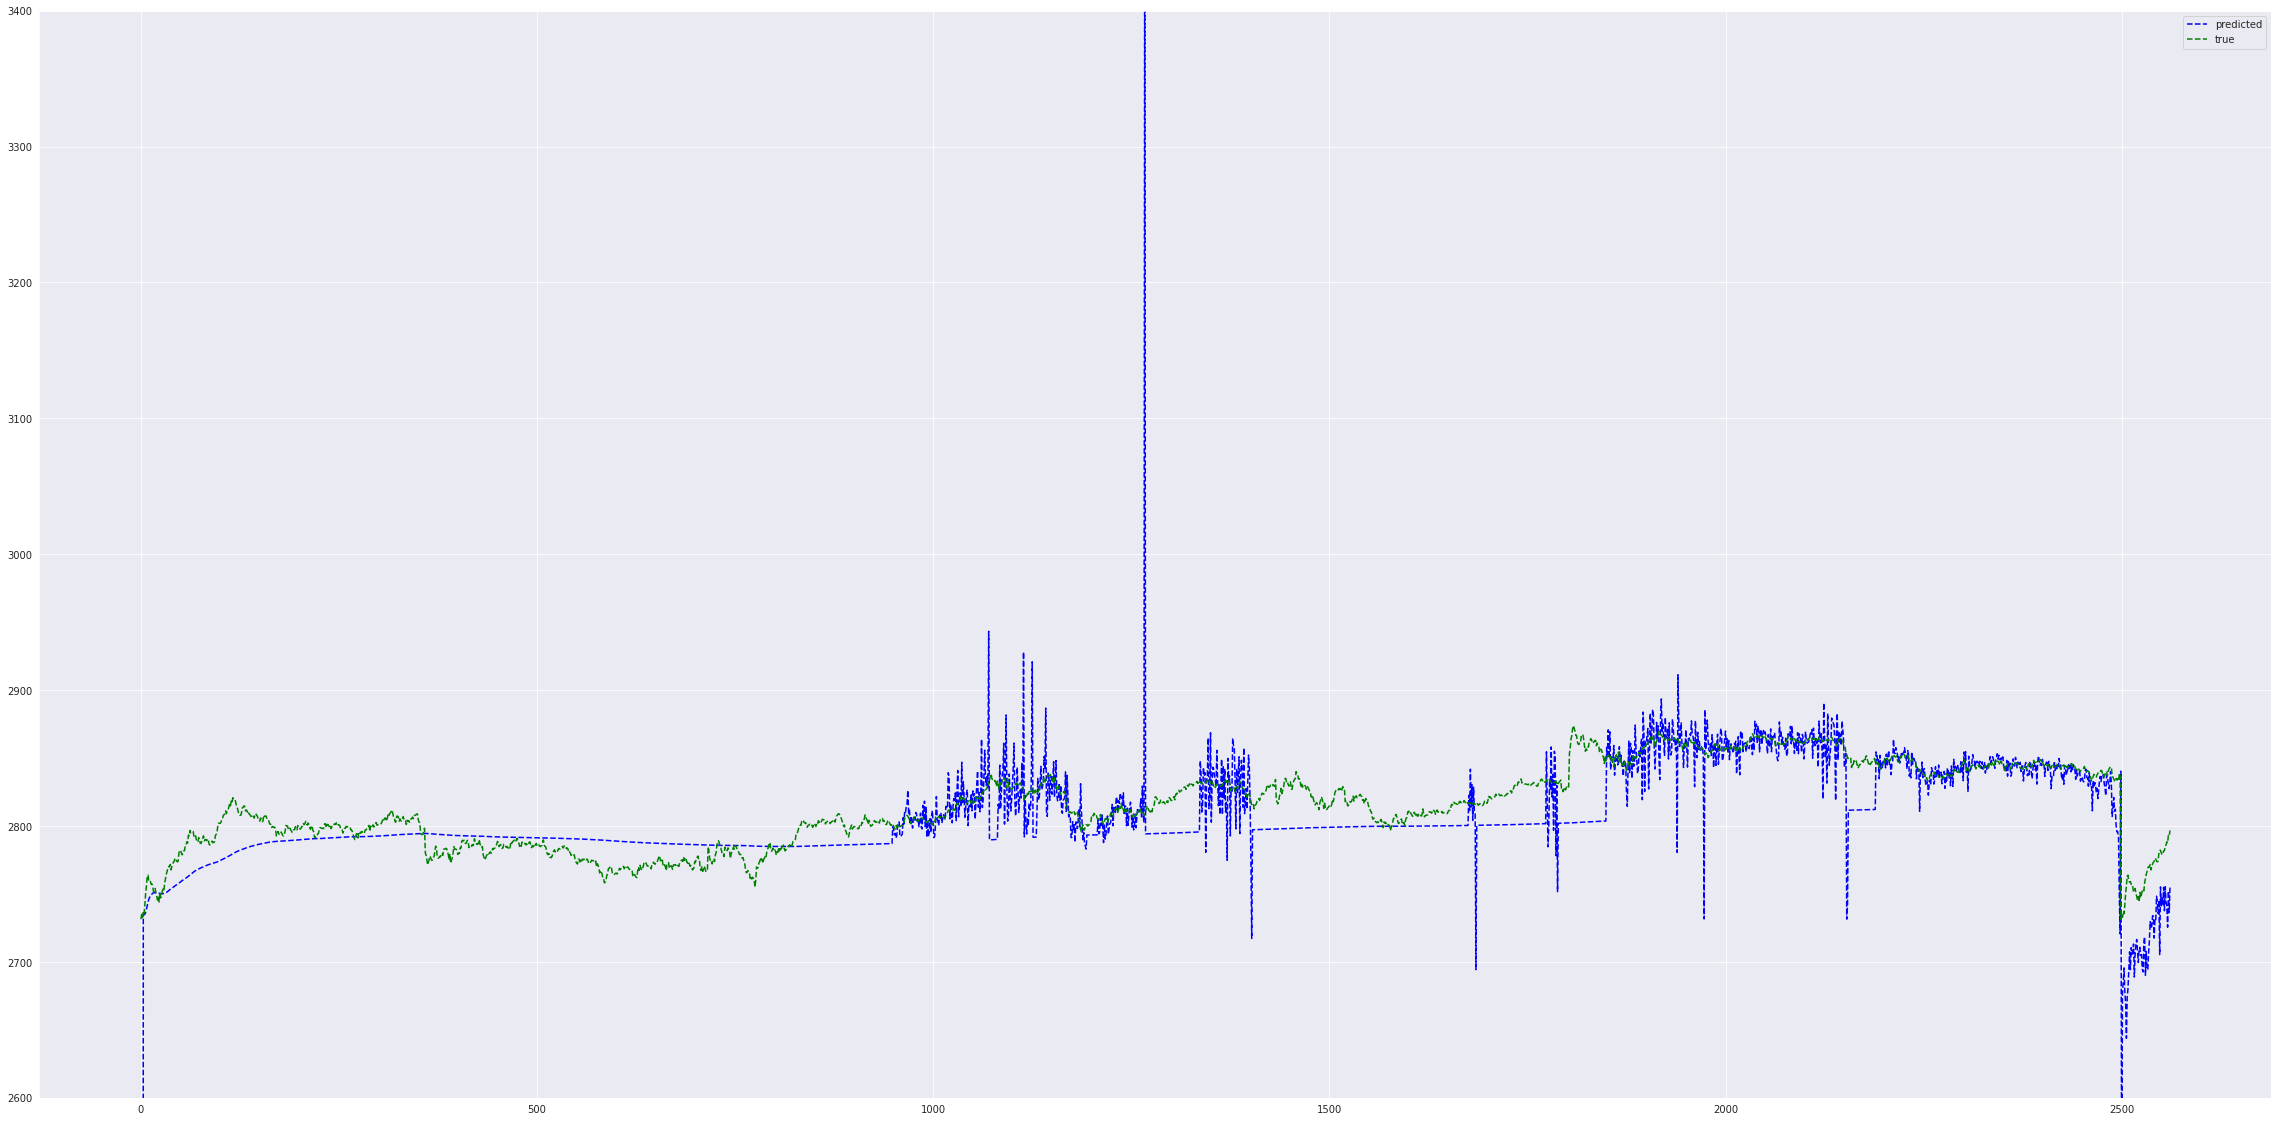

In [245]:
colab = False
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
if colab == True: 
  y_true = np.load('/content/y_true.npy', allow_pickle=True)
  y_pred =  np.load('/content/y_pred.npy', allow_pickle=True)
else: 
  y_true = np.load('y_true.npy', allow_pickle=True)
  y_pred =  np.load('y_pred.npy', allow_pickle=True)

y_true = np.array(y_true).astype(float)
y_pred = np.array(y_pred).astype(float)
plt.figure(figsize=(40,20))
plt.plot(y_pred, '--', c='b', label='predicted')
plt.plot(y_true, '--',c='g', label='true' )
plt.ylim((2600,3400))
plt.legend()
plt.show()

## Sklearn comparison 


In order to see if the online learning adds value to the prediction, we compare our models to some sklearn implementations. As we saw before, our models seem to output the current value as a prediction for the next value. Let's see if a batch regression model can perform well:

In [246]:
import sklearn
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [247]:
def metrics_sklearn(ytrue, ypred):
  mae = mean_absolute_error(ytrue, ypred)
  mse = mean_squared_error(ytrue, ypred)
  rmse = mean_squared_error(ytrue, ypred, squared=False)
  return mae, mse, rmse

In [248]:
X,y = construction_dataset_sklearn(ticker='GOOGL')

In [249]:
Xtrain, Xtest= np.split(X, [int(.8661 *len(X))])
ytrain, ytest= np.split(y, [int(.8661 *len(y))])


We splitted the data in a time series aspect : 5 days for the train and 1 day for the test set.

### Linear regression 

In [250]:
reg = LinearRegression().fit(Xtrain, ytrain)
pred = reg.predict(Xtest)
mae_lr, mse_lr, rmse_lr = metrics_sklearn(ytest, pred)

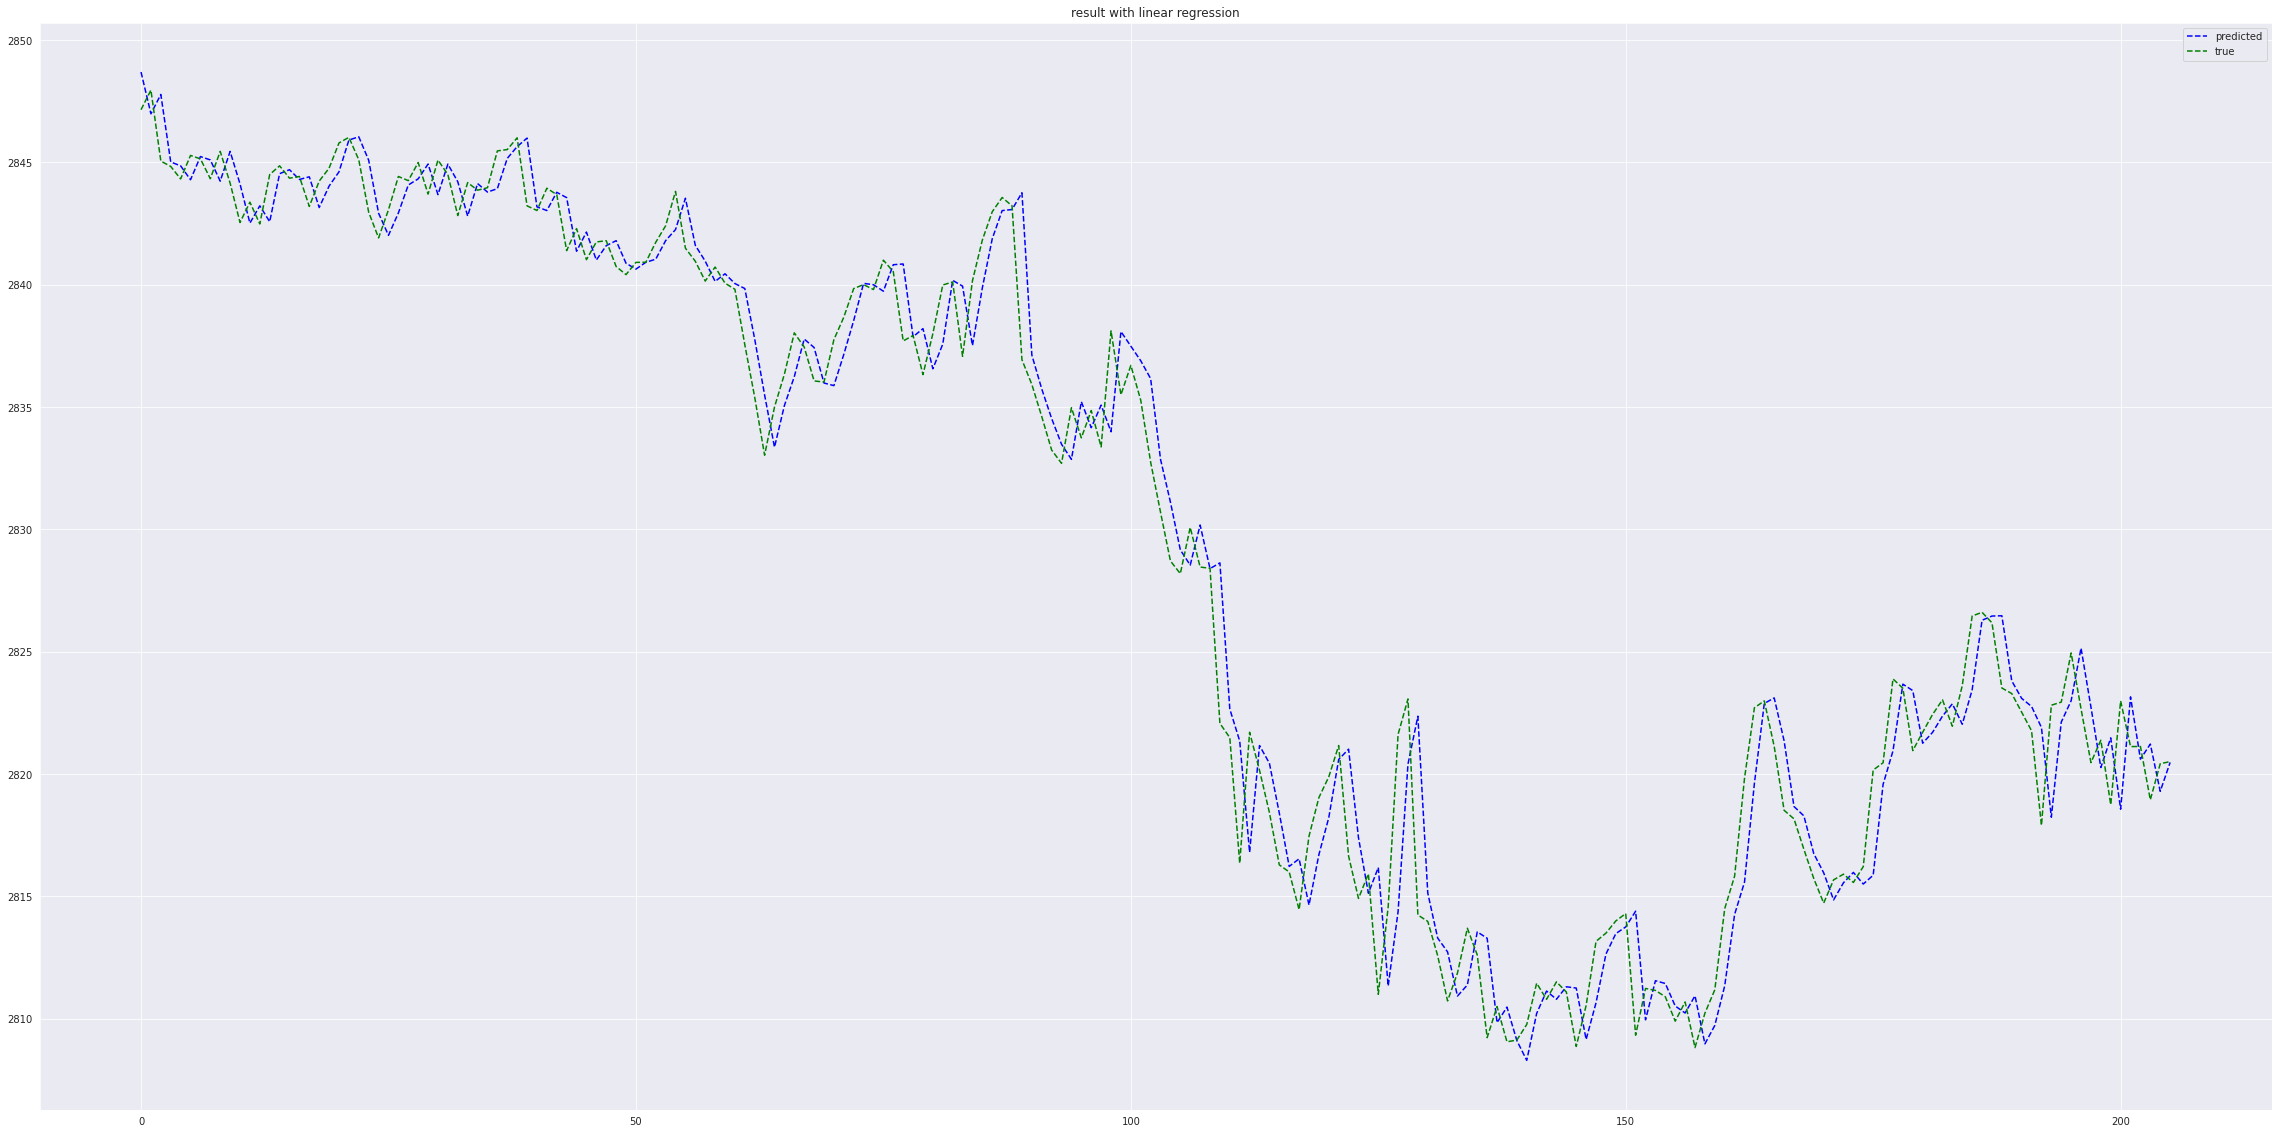

In [251]:
plt.figure(figsize=(40,20))
plt.plot(pred, '--', c='b', label='predicted')
plt.plot(ytest.values, '--',c='g', label='true' )
plt.legend()
plt.title('result with linear regression')
plt.show()

### Support vector machine 

In [252]:
sv = sklearn.svm.SVR().fit(Xtrain,ytrain)
predsv = sv.predict(Xtest)
mae_sv, mse_sv, rmse_sv = metrics_sklearn(ytest, predsv)

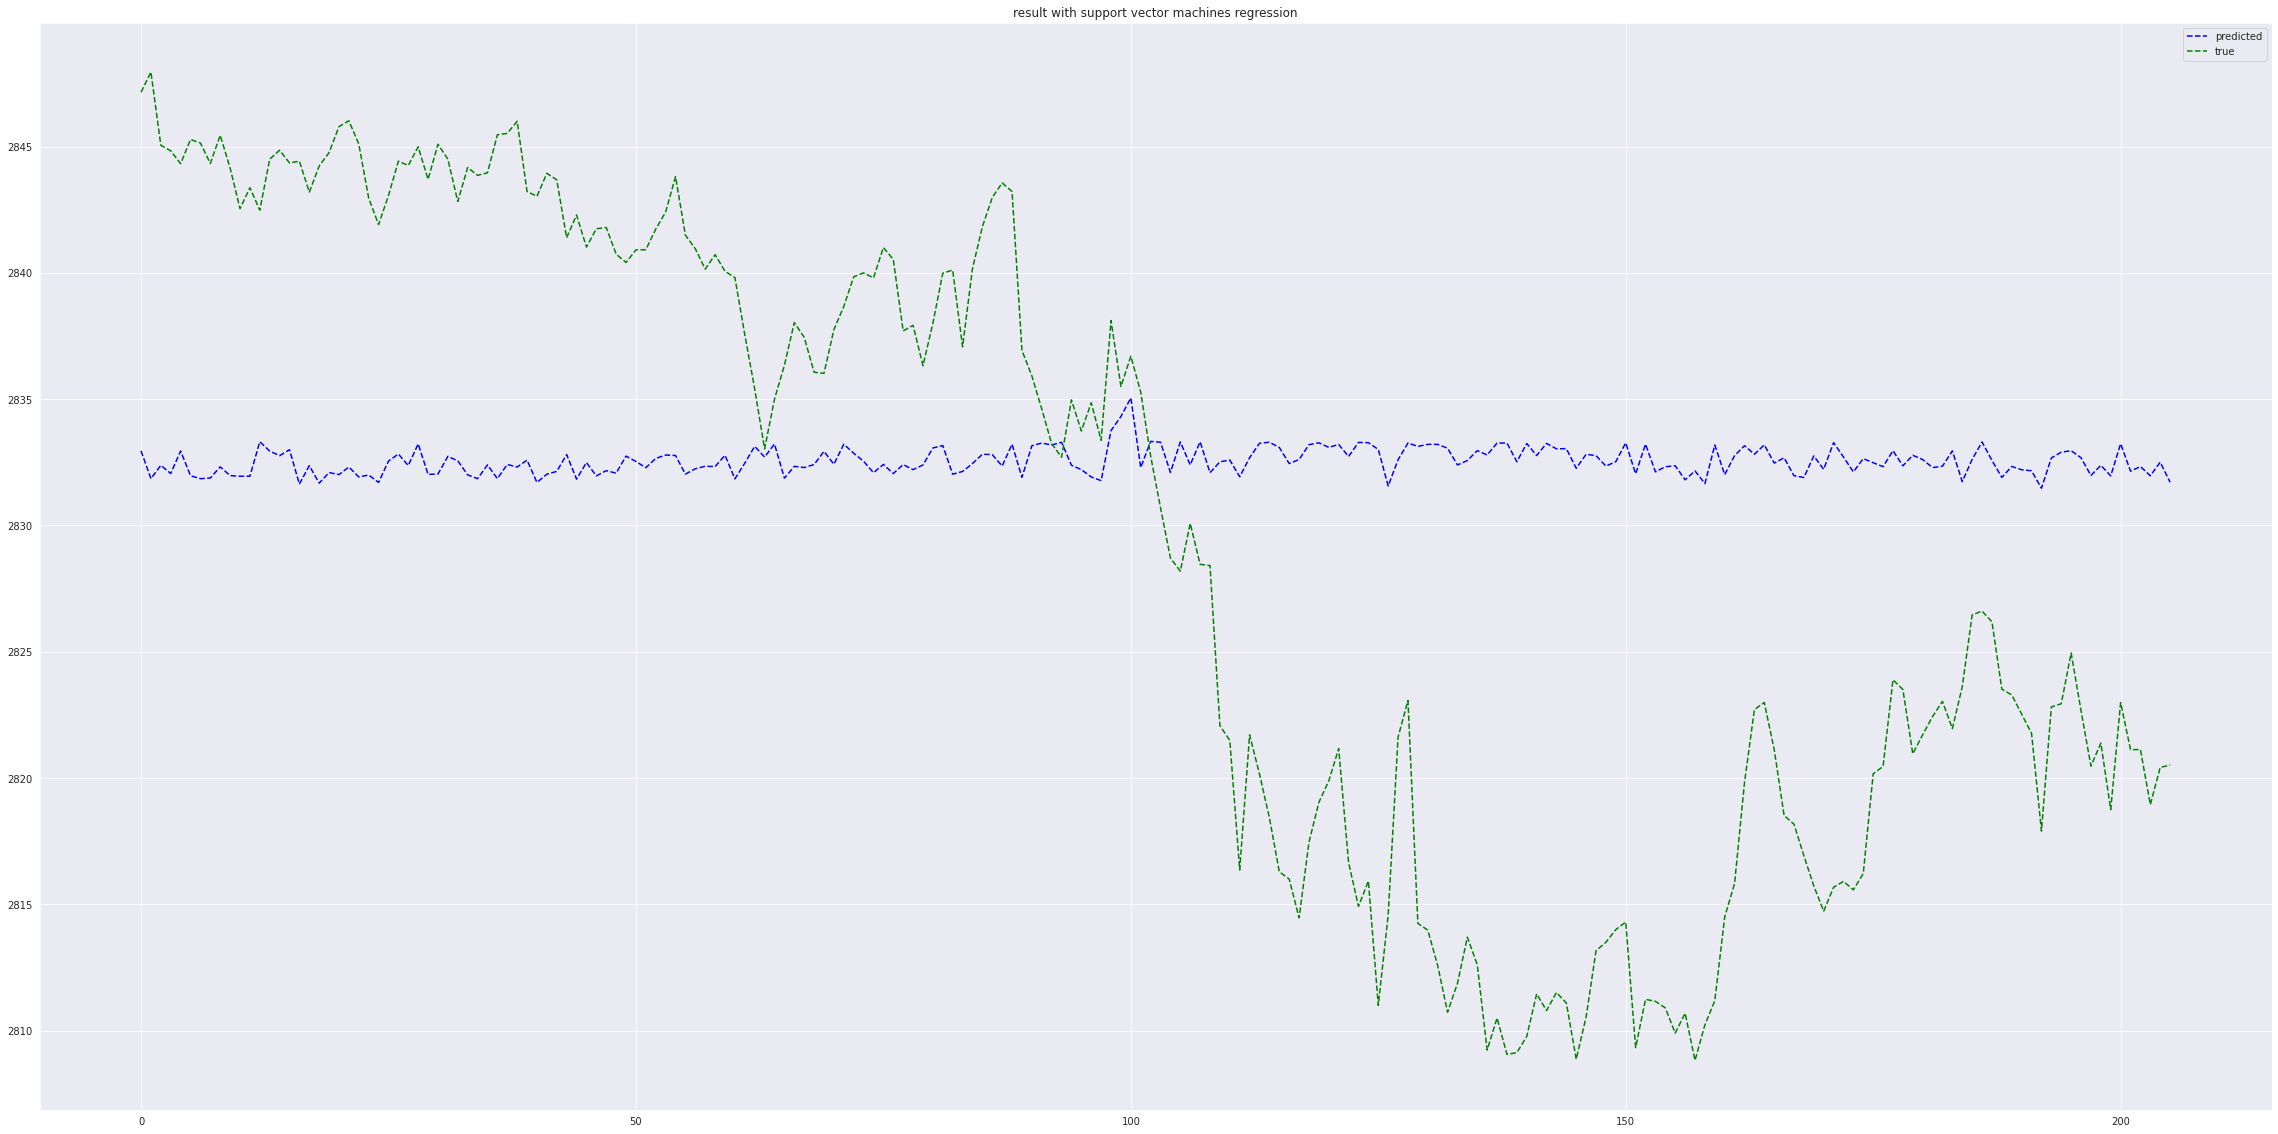

In [253]:
plt.figure(figsize=(40,20))
plt.plot(predsv, '--', c='b', label='predicted')
plt.plot(ytest.values, '--',c='g', label='true' )
plt.legend()
plt.title('result with support vector machines regression')
plt.show()

### Stochastic gradient descent

In [254]:
sgd = SGDRegressor().fit(Xtrain,ytrain)
predsgd = sgd.predict(Xtest)
mae_sgd, mse_sgd, rmse_sgd = metrics_sklearn(ytest, predsgd)

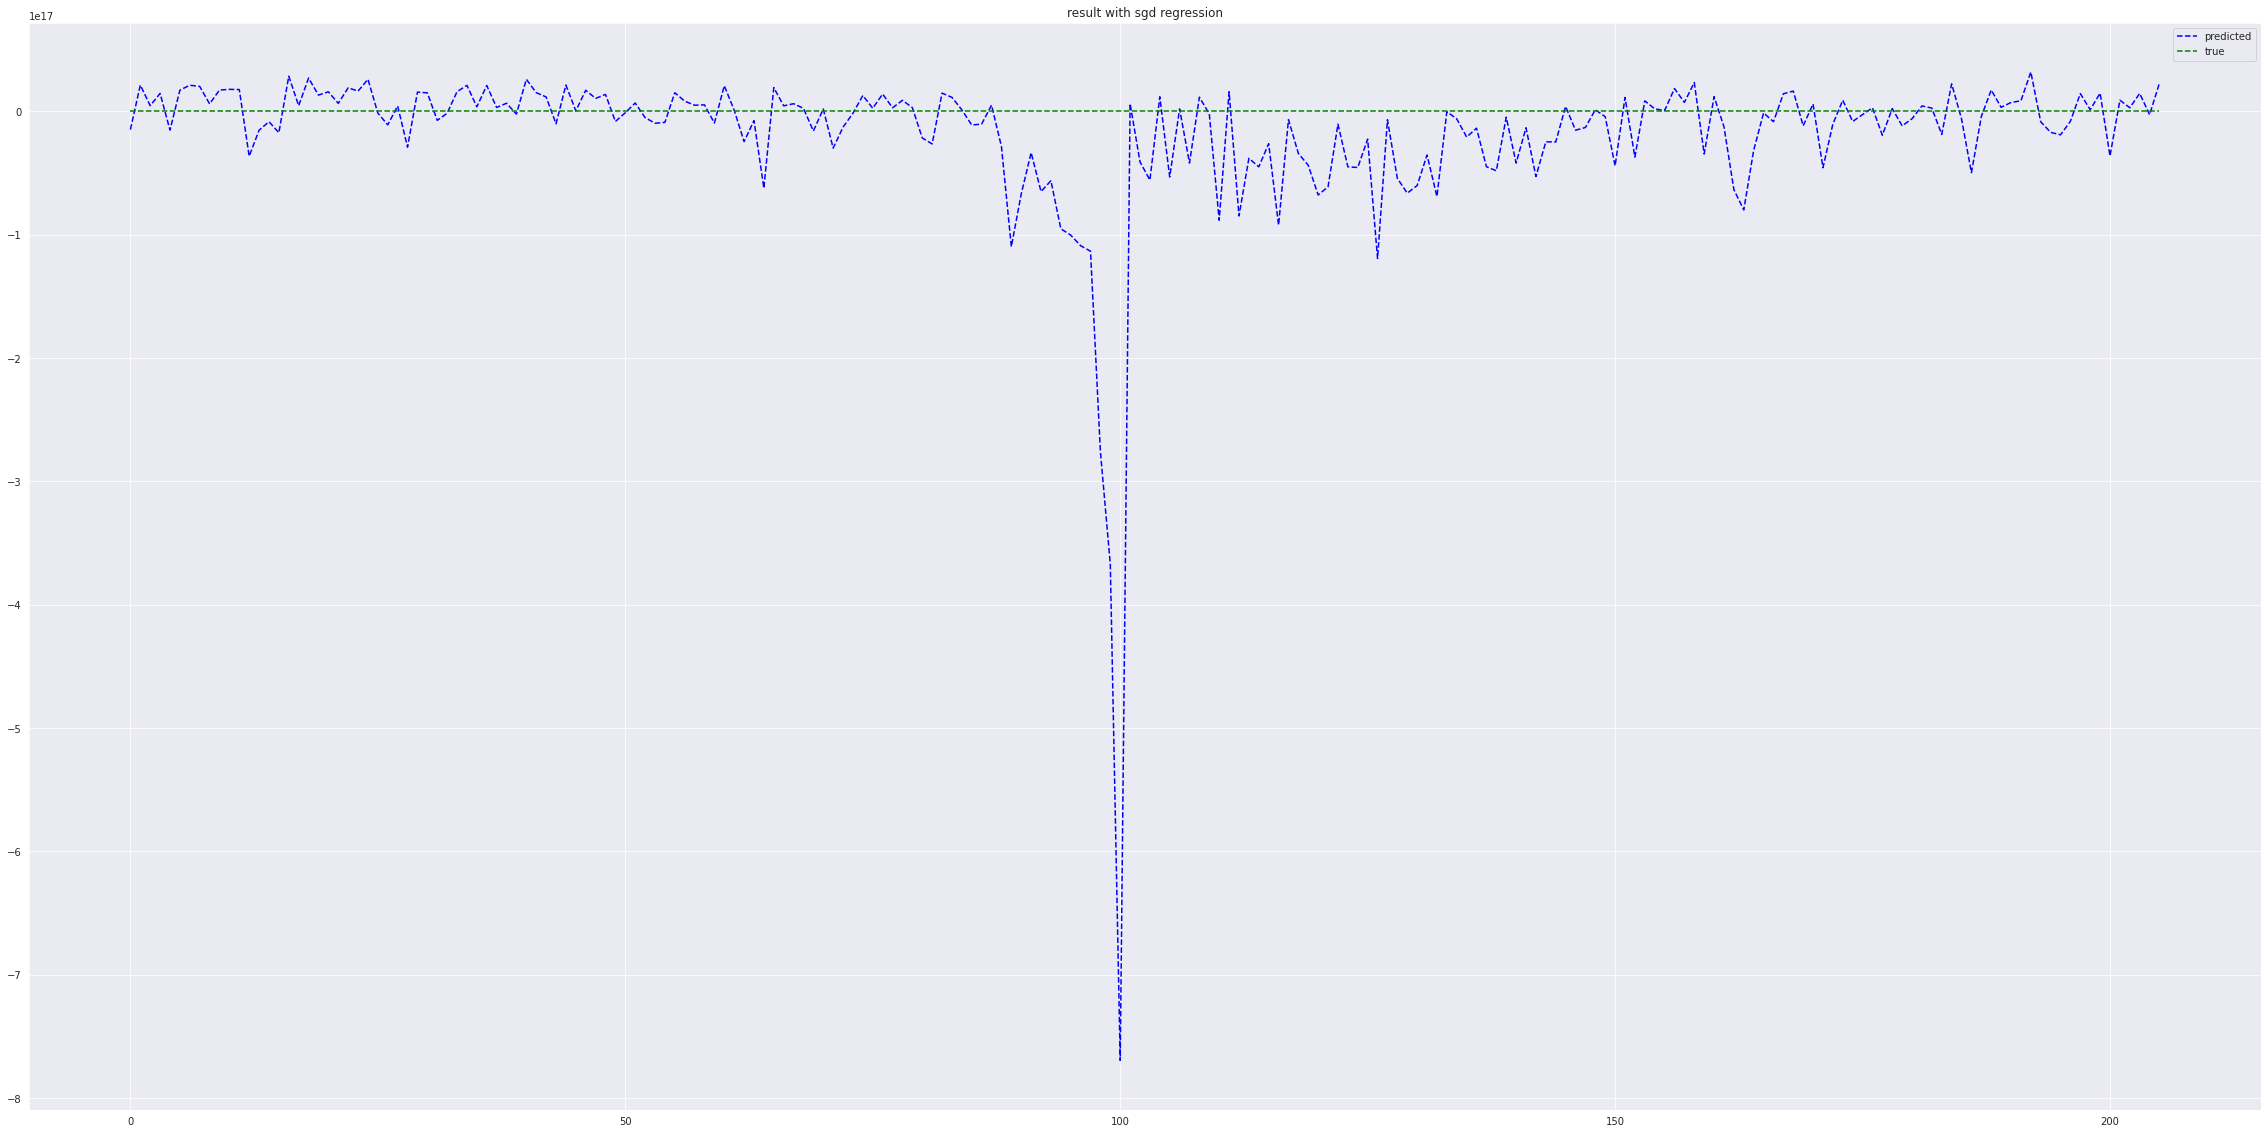

In [255]:
plt.figure(figsize=(40,20))
plt.plot(predsgd, '--', c='b', label='predicted')
plt.plot(ytest.values, '--',c='g', label='true' )
plt.legend()
plt.title('result with sgd regression')
plt.show()

Finally, the linear regression is by far the best. The predicted curve is the real curve but shifted by one minute. In this case, the results are very good because the closing price does not have time to change much in 1 minute. 

In [256]:
met = {'linear': [mae_lr, mse_lr, rmse_lr], 'svm': [mae_sv, mse_sv, rmse_sv], 'sgd':[mae_sgd, mse_sgd, rmse_sgd]}
met_sk = pd.DataFrame(met, index=['mae', 'mse', 'rmse'])

print('table of results of sklearn models for google stocks')
met_sk

table of results of sklearn models for google stocks


,linear,svm,sgd
mae,1.531271,11.658124,2.885778e+16
mse,4.261786,169.252347,4.955826e+33
rmse,2.064409,13.009702,7.039762e+16
